In [1]:
%load_ext memory_profiler

In [2]:
%load_ext autoreload
%autoreload 2 

from utils.data_download import download_data_with_animation, unzip_data


# Download data

In [3]:
# data will only be downloaed when the output file does not exist. In this case the file is ./data/data.zip
# if there is any issues remove everything under ./data and run the code again
url='https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F27069%2F46974%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240422%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240422T195446Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D27f3460b8b1512fc77d5fa919e5f7471c55fe552037869b78d43ddb33f80831a03ed39077650fd90b858ed2f101d2f468053a7199462f3513d0b8dcc100674f5469a5c0a008151acc0041a3bc7074be4d33b2d65462aa5f4e6988f27c8e89737c60fe8dfc0a245cd3915303c5e4488db745aafae9a1a4e6caf34a0000fed7eec3d0a6723983064916e2e2993cc94612de815d32cc9d345622158e7569c4cc0d541cb2b5d0d705461e3821e7c881248dc22390f1a2fed45f2794a442fd3bbb4d727151d4eb5390f37b3a1d167facb8ea5c5b8b79a054e93e90371a96b2c1e3be8549bd09c9a37278fcfeb38aba093157906271145184ddc0f32799f1013733631'
download_data_with_animation(url, "./data/data.zip")


./data/data.zip already exists, skipping download.


# unzip data

In [4]:
# data will only be unzipped when the output folder does not exist. In this case the folder is ./data/unziped_data
# if there is any issues remove everything under ./data/** and run the code again
unzip_data("./data/data.zip", "./data/unzipped_data/")

./data/unzipped_data/ already exists, skipping unzip.


In [5]:
# get all the data files 
import os
data_files = [] 
for root, dirs, files in os.walk("./data/unzipped_data/") :
	for file in files:
		data_files.append( os.path.join(root, file).replace('\\', '/') )
  
data_files


['./data/unzipped_data/cv10_labels.npy',
 './data/unzipped_data/test10_labels.npy',
 './data/unzipped_data/cv10_data/cv10_data.npy',
 './data/unzipped_data/test10_data/test10_data.npy',
 './data/unzipped_data/training10_0/training10_0.tfrecords',
 './data/unzipped_data/training10_1/training10_1.tfrecords',
 './data/unzipped_data/training10_2/training10_2.tfrecords',
 './data/unzipped_data/training10_3/training10_3.tfrecords',
 './data/unzipped_data/training10_4/training10_4.tfrecords']

In [6]:
training_files = [file for file in data_files if "training" in file]
training_files

['./data/unzipped_data/training10_0/training10_0.tfrecords',
 './data/unzipped_data/training10_1/training10_1.tfrecords',
 './data/unzipped_data/training10_2/training10_2.tfrecords',
 './data/unzipped_data/training10_3/training10_3.tfrecords',
 './data/unzipped_data/training10_4/training10_4.tfrecords']

# Loading training data
Read the data from the training files 

The training data is being given in tfrecords (tensorflow files). need to convert it to numpy arrays


In [7]:
import tensorflow as tf
from typing import List, Tuple, TypedDict
import numpy as np 

data_type = TypedDict(
    "data_type", {"label": List[np.number], "data": List[tf.Tensor]}
)

def read_tf_data(file:str, storing_dict: data_type):
    def parse_function(example_proto):
        return tf.io.parse_single_example(example_proto, {
            'label': tf.io.FixedLenFeature([], tf.int64),
            'label_normal': tf.io.FixedLenFeature([], tf.int64),
            'image': tf.io.FixedLenFeature([], tf.string)
        })

    # Extract the data
    with tf.device('/CPU:0'): # else is filled with GPU memory
        raw_data = tf.data.TFRecordDataset([file])
        parsed_dataset = raw_data.map(parse_function)
    
    for element in parsed_dataset:
        with tf.device('/CPU:0'): # else is filled with GPU memory
            image = tf.io.decode_raw(element['image'], tf.uint8) # shape = (89401,0) - 299*299 = 89401
            image = tf.reshape(image, [299, 299, 1]) # gray scale image
            label = np.int8(element['label_normal'].numpy())
            storing_dict["label"].append(label)
            storing_dict["data"].append(image)


2024-05-03 18:28:18.956305: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-03 18:28:20.058832: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
%%memit

training_data :data_type = {"label": [], "data": []}   

for training_file in training_files:
	read_tf_data( training_file, training_data )

2024-05-03 18:28:24.604251: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 18:28:24.677749: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 18:28:24.677791: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 18:28:24.679974: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 18:28:24.680021: I external/local_xla/xla/stream_executor

peak memory: 5670.36 MiB, increment: 4971.46 MiB


2024-05-03 18:29:14.580993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
print(training_data["label"][0]); print(training_data["data"][0].shape)
assert len(training_data["label"]) == len(training_data["data"])

0
(299, 299, 1)


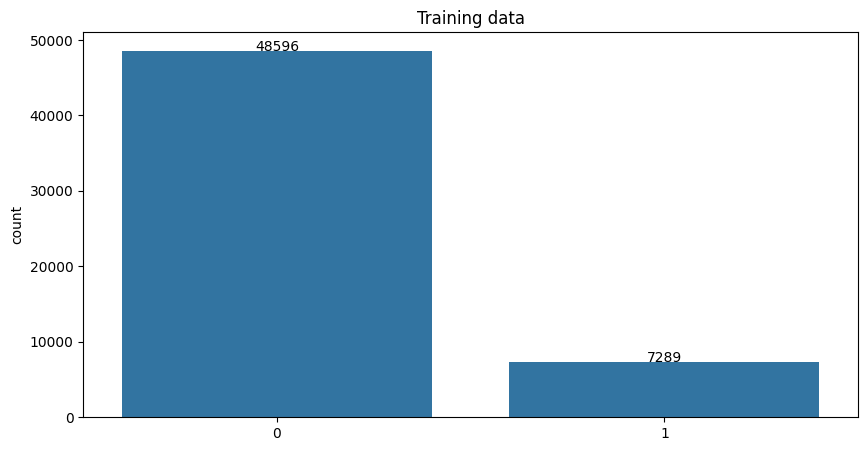

peak memory: 5746.36 MiB, increment: 75.86 MiB


In [10]:
%%memit

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.figure(figsize=(10, 5))

sns.countplot(x=training_data['label'])
plt.title("Training data")
# add labels on top of the data 
# add labels on top of the data( note there is only 2 cathegories 1, 0) 
for i in range(2):
	plt.text(i, training_data['label'].count(i), training_data['label'].count(i), ha = 'center')  # type: ignore
plt.show()


In [11]:
%%memit

nrows = 5
ncols = 5

plt.figure(figsize=(20, 20))
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(training_data["data"][i], )
    plt.title(str(training_data["label"][i]))
    # Remove the axis
    plt.axis('off')

# Show the plot
# plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()

peak memory: 5783.70 MiB, increment: 41.84 MiB


# Loaing test data

In [11]:
test_files =  './data/unzipped_data/test10_data/test10_data.npy'
test_files_labels =  './data/unzipped_data/test10_labels.npy'

cross_validation_files =  './data/unzipped_data/cv10_data/cv10_data.npy'
cross_validation_files_labels = './data/unzipped_data/cv10_labels.npy'


In [12]:
%%memit

test_data_ng = np.load( test_files)
test_data_labels = np.load(  test_files_labels) 
cv_data_ng = np.load( cross_validation_files)
cv_data_labels = np.load( cross_validation_files_labels)


peak memory: 7053.27 MiB, increment: 1307.87 MiB


In [13]:
test_data_ng.shape # an array of 3d arrays, but need to be reshaped to 2d arrays
# #### Keep images at 3rd dimension, since CNN work better at 3rd dimension ( )
# # # # reshape the data to 2d arrays
# test_data = np.array([x.reshape(x.shape[0], -1) for x in test_data])
# test_data.shape

(7682, 299, 299, 1)

# Data issue 
The data from CV only contains only calcifications and test files only contain masses.  

"**Note** - The data has been separated into training and test as per the division in the CBIS-DDSM dataset. The test files have been divided equally into test and validation data. However the split between test and validation data was done incorrectly, resulted in the test numpy files containing only masses and the validation files containing only calcifications. These files should be combined in order to have balanced and complete test data.
"

In [14]:
len(cv_data_ng) == len(cv_data_labels) # True

True

In [15]:
%%memit

cv_data : data_type = {'data': [], 'label': []}
test_data : data_type = {'data': [], 'label': []}
n_test = []  # data, label 
n_cv = [] # data, label 
for i in range( len(cv_data_ng)):
	if i%2: # odd 	
		n_test.append(   (cv_data_ng[i], cv_data_labels[i])   )
		n_test.append(   (test_data_ng[i], test_data_labels[i])   )
	else:
		n_cv.append(   (cv_data_ng[i], cv_data_labels[i])   )
		n_cv.append(   (test_data_ng[i], test_data_labels[i])   )

cv_data['data'] = [x[0] for x in n_cv]
cv_data['label'] = [np.int8(1) if x[1]>0 else np.int8(0) for x in n_cv]

test_data['data'] = [x[0] for x in n_test]
test_data['label'] = [np.int8(1) if x[1]>0 else np.int8(0) for x in n_test]

peak memory: 7054.15 MiB, increment: 0.82 MiB


In [16]:
type(cv_data['label'][0])

numpy.int8

# Visualize the test data 

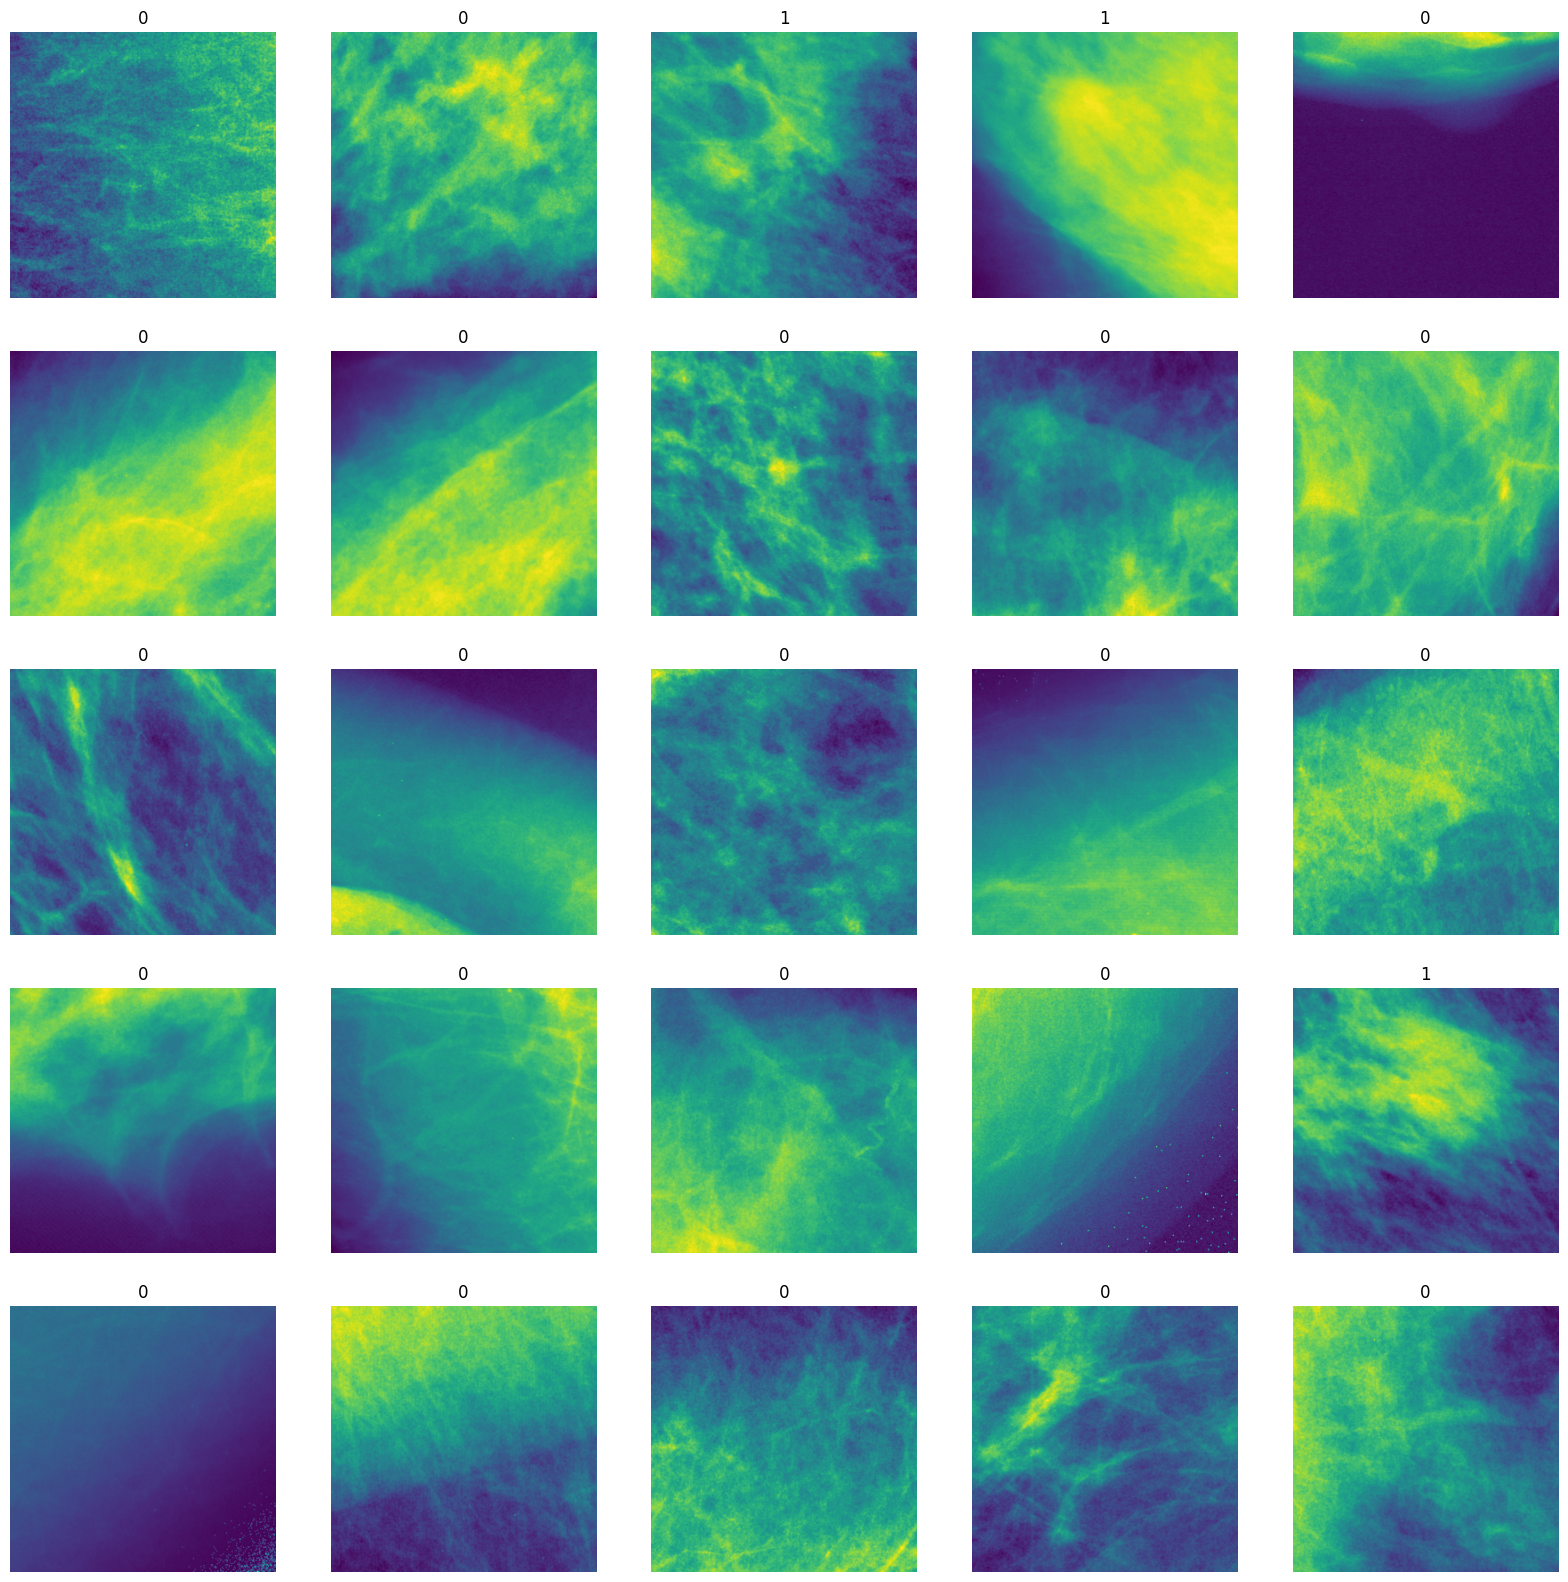

peak memory: 7103.64 MiB, increment: 49.49 MiB


In [17]:
%%memit

nrows = 5
ncols = 5

plt.figure(figsize=(20, 20))
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(cv_data["data"][i], )
    plt.title(str(cv_data["label"][i]))
    # Remove the axis
    plt.axis('off')

# Show the plot
# plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()

In [18]:
%%memit

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=cv_data['label'])
plt.title("Cross Validation Data")
plt.subplot(1, 2, 2)
plt.title("Test Data")
sns.countplot(x=test_data['label'])

plt.show()


peak memory: 7081.19 MiB, increment: 0.00 MiB


# Training Model

In [19]:
import tensorflow as tf
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.models import Sequential
from keras import layers, models
import keras 


In [21]:
# x,y = np.array(training_data['data']), np.array(training_data["label"])
# x_cv, y_cv = np.array(cv_data['data']), np.array(cv_data['label'])

In [22]:
# del training_data
# del cv_data

In [23]:
# train_dataset = tf.data.Dataset.from_tensor_slices( x, y) 
# cv_dataset = tf.data.Dataset.from_tensor_slices(x_cv,y_cv) 
# 
# # Shuffle and batch the datasets
# train_dataset = train_dataset.shuffle(buffer_size=512).batch(8)
# cv_dataset = cv_dataset.batch(8)


In [55]:

# allocating the data to the memory, with a small batch size. Previously the training was not happening.

def generator(data, labels):
    for d, l in zip(data, labels):
        yield d, l

# Convert the data to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_generator(generator, args=[training_data['data'], training_data["label"]], output_signature=(
    tf.TensorSpec(shape=(299, 299, 1), dtype=tf.uint8),
    tf.TensorSpec(shape=(), dtype=tf.uint8)))
cv_dataset = tf.data.Dataset.from_generator(generator, args=[cv_data['data'], cv_data['label']], output_signature=(
    tf.TensorSpec(shape=(299, 299, 1), dtype=tf.uint8),
    tf.TensorSpec(shape=(), dtype=tf.uint8)))

# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)
cv_dataset = cv_dataset.batch(64)

In [53]:
test_dataset = tf.data.Dataset.from_generator(generator, args=[test_data['data'], test_data['label']], output_signature=(
    tf.TensorSpec(shape=(299, 299, 1), dtype=tf.uint8),
    tf.TensorSpec(shape=(), dtype=tf.uint8)))
test_dataset = test_dataset.batch(64) 

In [23]:

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Physical devices cannot be modified after being initialized


In [26]:
%%memit

model = Sequential()
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten

model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1),input_shape=(299,299,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(256,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()


with tf.device('/device:GPU:0'):
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(train_dataset, validation_data=cv_dataset, epochs=2)
    loss_value , accuracy = model.evaluate(cv_dataset)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 299, 299, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 299, 299, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 38, 38, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 38, 38, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 38, 38, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 38, 38, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 19, 19, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 19, 19, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 19, 19, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 5, 5, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 5, 5, 32)       │             

 Total params: 775,425 (2.96 MB)

 Trainable params: 775,425 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2


I0000 00:00:1713896834.017077   39660 service.cc:145] XLA service 0x7f3c30010cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713896834.017158   39660 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-04-23 18:27:14.076488: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-23 18:27:14.387367: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


      5/Unknown 17s 33ms/step - accuracy: 0.4467 - loss: 13.4753

I0000 00:00:1713896846.040793   39660 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  13972/Unknown 204s 13ms/step - accuracy: 0.8662 - loss: 0.4874

2024-04-23 18:30:33.000424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 18:30:33.000801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 216s 14ms/step - accuracy: 0.8662 - loss: 0.4874 - val_accuracy: 0.8655 - val_loss: 0.3960
Epoch 2/2


2024-04-23 18:30:44.650504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 18:30:44.650559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 18:30:44.650573: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 18:30:44.650600: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8701 - loss: 0.3905

2024-04-23 18:33:38.249656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 18:33:38.249698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 18:33:38.249709: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 18:33:38.249736: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 183s 13ms/step - accuracy: 0.8701 - loss: 0.3905 - val_accuracy: 0.8655 - val_loss: 0.3948
     19/Unknown 0s 6ms/step - accuracy: 0.8336 - loss: 0.4548

2024-04-23 18:33:47.657045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 18:33:47.657096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 18:33:47.657108: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 18:33:47.657134: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1921/1921 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8604 - loss: 0.4045
peak memory: 21250.15 MiB, increment: 6121.54 MiB


2024-04-23 18:33:58.200389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 18:33:58.200446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 18:33:58.200457: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 18:33:58.200485: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


In [28]:
history2 = model.fit(train_dataset, validation_data=cv_dataset, epochs=4)
loss_value , accuracy = model.evaluate(cv_dataset)

Epoch 1/4
  13972/Unknown 182s 13ms/step - accuracy: 0.8702 - loss: 0.3873

2024-04-23 18:39:45.372063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 18:39:45.372146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 191s 14ms/step - accuracy: 0.8702 - loss: 0.3873 - val_accuracy: 0.8655 - val_loss: 0.3954
Epoch 2/4


2024-04-23 18:39:55.182996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 18:39:55.183111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8702 - loss: 0.3890

2024-04-23 18:42:58.618993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 18:42:58.619049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 18:42:58.619062: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 18:42:58.619092: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 193s 14ms/step - accuracy: 0.8702 - loss: 0.3890 - val_accuracy: 0.8655 - val_loss: 0.3953
Epoch 3/4


2024-04-23 18:43:08.173281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 18:43:08.173326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 18:43:08.173337: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 18:43:08.173363: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13969/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8697 - loss: 0.3959

2024-04-23 18:45:55.162044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 18:45:55.162215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 177s 13ms/step - accuracy: 0.8697 - loss: 0.3959 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 4/4


2024-04-23 18:46:05.094035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 18:46:05.094093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 18:46:05.094106: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 18:46:05.094135: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8702 - loss: 0.4272

2024-04-23 18:49:03.773908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 18:49:03.773987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 188s 13ms/step - accuracy: 0.8702 - loss: 0.4272 - val_accuracy: 0.8655 - val_loss: 0.3947
     18/Unknown 0s 6ms/step - accuracy: 0.8316 - loss: 0.4587

2024-04-23 18:49:13.507131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 18:49:13.507211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1921/1921 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8604 - loss: 0.4045


2024-04-23 18:49:24.182275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 18:49:24.182318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 18:49:24.182331: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 18:49:24.182359: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


In [29]:
loss_value , accuracy

(0.39474964141845703, 0.8655298352241516)

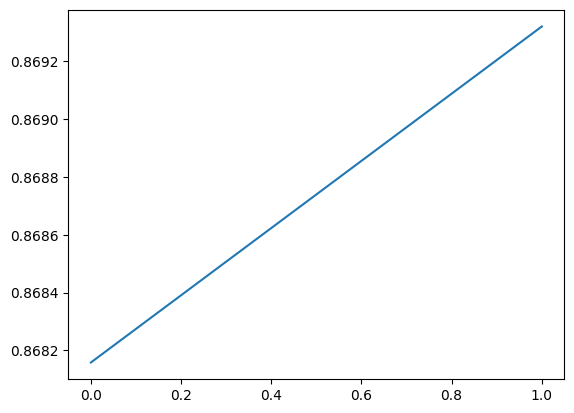

In [31]:
# visualize the history 
plt.plot(history.history['accuracy'])

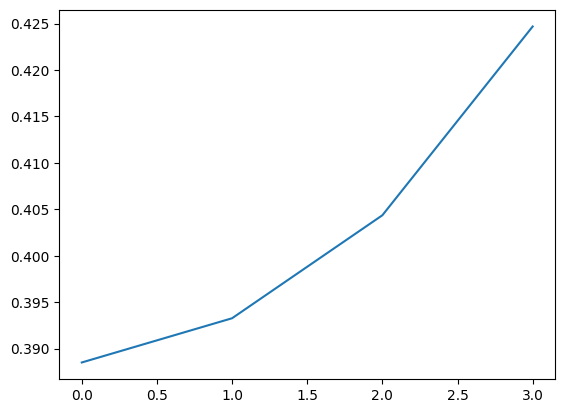

In [35]:
history2.history
plt.plot(history2.history['loss'])

In [36]:
history3 = model.fit(train_dataset, validation_data=cv_dataset, epochs=100)
loss_value , accuracy = model.evaluate(cv_dataset)

Epoch 1/100
  13968/Unknown 174s 12ms/step - accuracy: 0.8697 - loss: 0.3986

2024-04-23 18:56:08.821081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 18:56:08.821156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 184s 13ms/step - accuracy: 0.8697 - loss: 0.3986 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 2/100


2024-04-23 18:56:18.222423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 18:56:18.222480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 18:56:18.222495: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 18:56:18.222523: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8704 - loss: 0.4180

2024-04-23 18:59:14.761221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 18:59:14.761350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


KeyboardInterrupt: 

In [41]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('./best_model.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, )
history4 = model.fit(train_dataset, validation_data=cv_dataset, epochs=100, callbacks=[checkpoint])


Epoch 1/100


  13969/Unknown 174s 12ms/step - accuracy: 0.8701 - loss: 0.4151

2024-04-23 19:16:16.459941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:16:16.460014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 184s 13ms/step - accuracy: 0.8701 - loss: 0.4151 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 2/100


2024-04-23 19:16:25.892932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:16:25.892992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 19:16:25.893007: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 19:16:25.893036: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13968/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8700 - loss: 0.3971

2024-04-23 19:19:13.737956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:19:13.738025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 19:19:13.738043: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 19:19:13.738076: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 176s 13ms/step - accuracy: 0.8700 - loss: 0.3971 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 3/100


2024-04-23 19:19:21.582476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:19:21.582532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 19:19:21.582546: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 19:19:21.582574: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13969/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8702 - loss: 0.4018

2024-04-23 19:21:52.035594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:21:52.035664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 158s 11ms/step - accuracy: 0.8702 - loss: 0.4018 - val_accuracy: 0.8655 - val_loss: 0.3944
Epoch 4/100


2024-04-23 19:21:59.648040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:21:59.648083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 19:21:59.648096: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 19:21:59.648120: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8704 - loss: 0.4111

2024-04-23 19:24:30.029751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:24:30.029821: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 19:24:30.029853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 158s 11ms/step - accuracy: 0.8704 - loss: 0.4111 - val_accuracy: 0.8655 - val_loss: 0.3946
Epoch 5/100


2024-04-23 19:24:37.748538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:24:37.748588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 19:24:37.748603: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 19:24:37.748633: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13968/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8698 - loss: 0.3942

2024-04-23 19:27:10.033961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:27:10.034036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 160s 11ms/step - accuracy: 0.8698 - loss: 0.3942 - val_accuracy: 0.8655 - val_loss: 0.4051
Epoch 6/100


2024-04-23 19:27:18.086528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:27:18.086572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 19:27:18.086585: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 19:27:18.086612: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13969/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8703 - loss: 0.4614

2024-04-23 19:29:53.411059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:29:53.411128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 19:29:53.411164: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 163s 12ms/step - accuracy: 0.8703 - loss: 0.4614 - val_accuracy: 0.8655 - val_loss: 0.3945
Epoch 7/100


2024-04-23 19:30:01.503150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:30:01.503200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 19:30:01.503212: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 19:30:01.503254: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13968/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8706 - loss: 0.3861

2024-04-23 19:32:36.490271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:32:36.490336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 163s 12ms/step - accuracy: 0.8706 - loss: 0.3861 - val_accuracy: 0.8655 - val_loss: 0.5817
Epoch 8/100


2024-04-23 19:32:44.544794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:32:44.544847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 19:32:44.544859: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 19:32:44.544890: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13969/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8700 - loss: 0.9025

2024-04-23 19:35:18.899529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:35:18.899589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 163s 12ms/step - accuracy: 0.8700 - loss: 0.9024 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 9/100


2024-04-23 19:35:27.093743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:35:27.093796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 19:35:27.093840: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 19:35:27.093871: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8699 - loss: 0.3907

2024-04-23 19:38:01.436245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:38:01.436309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 162s 12ms/step - accuracy: 0.8699 - loss: 0.3907 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 10/100


2024-04-23 19:38:09.434403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:38:09.434446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 19:38:09.434459: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 19:38:09.434491: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8699 - loss: 0.3971

2024-04-23 19:40:43.412876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:40:43.412940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 162s 12ms/step - accuracy: 0.8699 - loss: 0.3971 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 11/100


2024-04-23 19:40:51.651975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:40:51.652023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 19:40:51.652036: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 19:40:51.652064: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8705 - loss: 0.4117

2024-04-23 19:43:26.474888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:43:26.474944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 163s 12ms/step - accuracy: 0.8705 - loss: 0.4117 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 12/100


2024-04-23 19:43:34.489849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:43:34.489905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 19:43:34.489919: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 19:43:34.489949: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13968/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8702 - loss: 0.3884

2024-04-23 19:46:11.624297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:46:11.624387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 169s 12ms/step - accuracy: 0.8702 - loss: 0.3884 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 13/100


2024-04-23 19:46:23.727821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:46:23.727896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 19:46:23.727917: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 19:46:23.727966: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8703 - loss: 0.4077

2024-04-23 19:49:31.450834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:49:31.450913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 197s 14ms/step - accuracy: 0.8703 - loss: 0.4077 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 14/100


2024-04-23 19:49:40.503689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:49:40.503763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 19:49:40.503779: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 19:49:40.503816: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8702 - loss: 0.3932

2024-04-23 19:52:28.951503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:52:28.951548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 19:52:28.951562: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 19:52:28.951588: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 176s 13ms/step - accuracy: 0.8702 - loss: 0.3932 - val_accuracy: 0.8655 - val_loss: 0.3934
Epoch 15/100


2024-04-23 19:52:36.610811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:52:36.610861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 19:52:36.610873: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 19:52:36.610904: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13967/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8704 - loss: 0.4892

2024-04-23 19:55:07.409169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:55:07.409229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 19:55:07.409245: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 19:55:07.409278: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 158s 11ms/step - accuracy: 0.8704 - loss: 0.4893 - val_accuracy: 0.8655 - val_loss: 0.3931
Epoch 16/100


2024-04-23 19:55:15.056669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:55:15.056719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 19:55:15.056731: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 19:55:15.056758: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13969/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8702 - loss: 0.4319

2024-04-23 19:57:44.850370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:57:44.850433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 157s 11ms/step - accuracy: 0.8702 - loss: 0.4319 - val_accuracy: 0.8655 - val_loss: 0.3945
Epoch 17/100


2024-04-23 19:57:52.355263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 19:57:52.355312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 19:57:52.355325: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 19:57:52.355351: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13967/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8709 - loss: 0.5034

2024-04-23 20:00:22.482210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:00:22.482281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 158s 11ms/step - accuracy: 0.8709 - loss: 0.5034 - val_accuracy: 0.8655 - val_loss: 0.4013
Epoch 18/100


2024-04-23 20:00:29.985350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:00:29.985397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 20:00:29.985410: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 20:00:29.985435: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13968/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8702 - loss: 0.4151

2024-04-23 20:02:59.671735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:02:59.671784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 20:02:59.671795: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 20:02:59.671822: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 157s 11ms/step - accuracy: 0.8702 - loss: 0.4151 - val_accuracy: 0.8655 - val_loss: 0.3942
Epoch 19/100


2024-04-23 20:03:07.193318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:03:07.193365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 20:03:07.193376: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 20:03:07.193401: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8702 - loss: 0.4098

2024-04-23 20:05:37.107234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:05:37.107323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 158s 11ms/step - accuracy: 0.8702 - loss: 0.4098 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 20/100


2024-04-23 20:05:44.751626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:05:44.751669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 20:05:44.751682: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 20:05:44.751710: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8705 - loss: 0.4700

2024-04-23 20:08:14.861043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:08:14.861134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 158s 11ms/step - accuracy: 0.8705 - loss: 0.4700 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 21/100


2024-04-23 20:08:22.407877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:08:22.407931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 20:08:22.407944: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 20:08:22.407976: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8704 - loss: 0.3948

2024-04-23 20:10:52.354116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:10:52.354172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 20:10:52.354185: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 20:10:52.354216: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 163s 12ms/step - accuracy: 0.8704 - loss: 0.3948 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 22/100


2024-04-23 20:11:05.576751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:11:05.576802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 20:11:05.576815: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 20:11:05.576844: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8699 - loss: 0.3971

2024-04-23 20:17:38.503090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:17:38.503237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 414s 30ms/step - accuracy: 0.8699 - loss: 0.3971 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 23/100


2024-04-23 20:18:00.074976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:18:00.075029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 20:18:00.075094: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 20:18:00.075131: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8709 - loss: 0.3899

2024-04-23 20:29:17.938763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:29:17.938944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 20:29:17.938968: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 20:29:17.939078: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 700s 50ms/step - accuracy: 0.8709 - loss: 0.3899 - val_accuracy: 0.8655 - val_loss: 0.3946
Epoch 24/100


2024-04-23 20:29:39.818376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:29:39.818439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 20:29:39.818457: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 20:29:39.818496: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8705 - loss: 0.4406

2024-04-23 20:35:15.497017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:35:15.497128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 354s 25ms/step - accuracy: 0.8705 - loss: 0.4406 - val_accuracy: 0.8655 - val_loss: 0.3942
Epoch 25/100


2024-04-23 20:35:34.160156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:35:34.160233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 20:35:34.160253: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 20:35:34.160294: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8705 - loss: 0.3924

2024-04-23 20:41:54.038588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:41:54.038694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 397s 28ms/step - accuracy: 0.8705 - loss: 0.3924 - val_accuracy: 0.8655 - val_loss: 0.3925
Epoch 26/100


2024-04-23 20:42:11.351312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:42:11.351369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 20:42:11.351385: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 20:42:11.351420: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8702 - loss: 0.5145

2024-04-23 20:47:31.585085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:47:31.585208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 337s 24ms/step - accuracy: 0.8702 - loss: 0.5145 - val_accuracy: 0.8655 - val_loss: 0.3935
Epoch 27/100


2024-04-23 20:47:48.896350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:47:48.896424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 20:47:48.896446: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 20:47:48.896496: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8702 - loss: 0.3936

2024-04-23 20:52:32.742662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:52:32.742717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 20:52:32.742734: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 20:52:32.742811: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 296s 21ms/step - accuracy: 0.8702 - loss: 0.3936 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 28/100


2024-04-23 20:52:45.401544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:52:45.401630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 20:52:45.401649: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 20:52:45.401687: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8705 - loss: 0.4004

2024-04-23 20:56:39.728414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:56:39.728516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 247s 18ms/step - accuracy: 0.8705 - loss: 0.4004 - val_accuracy: 0.8655 - val_loss: 0.3912
Epoch 29/100


2024-04-23 20:56:52.158106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 20:56:52.158162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 20:56:52.158179: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 20:56:52.158222: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8699 - loss: 0.4094

2024-04-23 21:00:38.355838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:00:38.355902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 21:00:38.355917: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 21:00:38.356019: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 238s 17ms/step - accuracy: 0.8699 - loss: 0.4094 - val_accuracy: 0.8655 - val_loss: 0.3919
Epoch 30/100


2024-04-23 21:00:50.727263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:00:50.727328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 21:00:50.727345: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 21:00:50.727382: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8702 - loss: 0.4007

2024-04-23 21:04:37.495902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:04:37.495996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 239s 17ms/step - accuracy: 0.8702 - loss: 0.4007 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 31/100


2024-04-23 21:04:50.165619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:04:50.165676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 21:04:50.165692: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 21:04:50.165723: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8708 - loss: 0.4036

2024-04-23 21:08:53.232776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:08:53.232863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 21:08:53.232881: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 21:08:53.232924: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 257s 18ms/step - accuracy: 0.8708 - loss: 0.4036 - val_accuracy: 0.8655 - val_loss: 0.3922
Epoch 32/100


2024-04-23 21:09:07.409686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:09:07.409759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 21:09:07.409775: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 21:09:07.409809: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8704 - loss: 0.4089

2024-04-23 21:13:12.033113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:13:12.033167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 21:13:12.033182: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 21:13:12.033216: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 259s 18ms/step - accuracy: 0.8704 - loss: 0.4089 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 33/100


2024-04-23 21:13:26.031022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:13:26.031087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 21:13:26.031168: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 21:13:26.031210: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8699 - loss: 0.5064

2024-04-23 21:17:12.537882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:17:12.537952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 21:17:12.538129: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 21:17:12.538177: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 239s 17ms/step - accuracy: 0.8699 - loss: 0.5065 - val_accuracy: 0.8655 - val_loss: 0.3924
Epoch 34/100


2024-04-23 21:17:25.110348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:17:25.110434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 21:17:25.110464: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 21:17:25.110529: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8703 - loss: 0.4082

2024-04-23 21:21:27.498467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:21:27.498599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 257s 18ms/step - accuracy: 0.8703 - loss: 0.4082 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 35/100


2024-04-23 21:21:41.769942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:21:41.770008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 21:21:41.770029: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 21:21:41.770066: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8705 - loss: 0.3854

2024-04-23 21:25:38.109760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:25:38.109836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 250s 18ms/step - accuracy: 0.8705 - loss: 0.3854 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 36/100


2024-04-23 21:25:51.371211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:25:51.371300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8702 - loss: 0.3860

2024-04-23 21:29:55.247256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:29:55.247337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 21:29:55.247404: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 21:29:55.247496: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 263s 19ms/step - accuracy: 0.8702 - loss: 0.3860 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 37/100


2024-04-23 21:30:14.806208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:30:14.806265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 21:30:14.806366: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 21:30:14.806408: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8704 - loss: 0.3856

2024-04-23 21:33:59.343077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:33:59.343312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 238s 17ms/step - accuracy: 0.8704 - loss: 0.3856 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 38/100


2024-04-23 21:34:13.057981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:34:13.058052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 21:34:13.058068: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 21:34:13.058100: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8706 - loss: 0.3852

2024-04-23 21:39:40.995152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:39:40.995209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 21:39:40.995226: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 21:39:40.995265: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 347s 25ms/step - accuracy: 0.8706 - loss: 0.3852 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 39/100


2024-04-23 21:39:59.654462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:39:59.654565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 21:39:59.654590: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 21:39:59.654660: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8701 - loss: 0.3863

2024-04-23 21:46:23.230320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:46:23.230415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 21:46:23.230435: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 21:46:23.230482: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 400s 29ms/step - accuracy: 0.8701 - loss: 0.3863 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 40/100


2024-04-23 21:46:39.597945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:46:39.598036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 21:46:39.598051: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 21:46:39.598083: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8700 - loss: 0.3864

2024-04-23 21:49:35.887978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:49:35.888064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 187s 13ms/step - accuracy: 0.8700 - loss: 0.3864 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 41/100


2024-04-23 21:49:46.350470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:49:46.350656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8704 - loss: 0.3857

2024-04-23 21:52:48.856874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:52:48.856975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 191s 14ms/step - accuracy: 0.8704 - loss: 0.3857 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 42/100


2024-04-23 21:52:57.350480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:52:57.350558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8698 - loss: 0.3868

2024-04-23 21:55:48.967468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:55:48.967590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 180s 13ms/step - accuracy: 0.8698 - loss: 0.3868 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 43/100


2024-04-23 21:55:57.022802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:55:57.022842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 21:55:57.022855: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 21:55:57.022879: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8700 - loss: 0.3865

2024-04-23 21:58:44.397042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:58:44.397102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 21:58:44.397118: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 21:58:44.397147: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 175s 12ms/step - accuracy: 0.8700 - loss: 0.3865 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 44/100


2024-04-23 21:58:52.032765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 21:58:52.032819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 21:58:52.032832: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 21:58:52.032860: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8704 - loss: 0.3856

2024-04-23 22:01:50.885701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:01:50.885775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 187s 13ms/step - accuracy: 0.8704 - loss: 0.3856 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 45/100


2024-04-23 22:01:58.732713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:01:58.732776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:01:58.732793: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:01:58.732826: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8704 - loss: 0.3857

2024-04-23 22:04:39.542177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:04:39.542239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:04:39.542255: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:04:39.542314: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 169s 12ms/step - accuracy: 0.8704 - loss: 0.3857 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 46/100


2024-04-23 22:04:47.381712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:04:47.381815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:04:47.381833: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:04:47.381884: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13969/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8700 - loss: 0.3865

2024-04-23 22:07:24.730936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:07:24.731020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 165s 12ms/step - accuracy: 0.8700 - loss: 0.3865 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 47/100


2024-04-23 22:07:32.560990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:07:32.561049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:07:32.561067: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:07:32.561096: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13967/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8700 - loss: 0.3865

2024-04-23 22:10:10.241838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:10:10.241932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 166s 12ms/step - accuracy: 0.8700 - loss: 0.3865 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 48/100


2024-04-23 22:10:18.120605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:10:18.120674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:10:18.120697: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:10:18.120734: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8698 - loss: 0.3868

2024-04-23 22:12:55.047884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:12:55.047961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 164s 12ms/step - accuracy: 0.8698 - loss: 0.3868 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 49/100


2024-04-23 22:13:02.516612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:13:02.516669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:13:02.516683: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:13:02.516708: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13969/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8699 - loss: 0.3889

2024-04-23 22:15:44.150579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:15:44.150641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:15:44.150656: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:15:44.150688: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 173s 12ms/step - accuracy: 0.8699 - loss: 0.3889 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 50/100


2024-04-23 22:15:55.148917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:15:55.148970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:15:55.148984: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:15:55.149011: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13968/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8706 - loss: 0.3853

2024-04-23 22:18:57.492869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:18:57.492952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 194s 14ms/step - accuracy: 0.8706 - loss: 0.3853 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 51/100


2024-04-23 22:19:09.282269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:19:09.282330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:19:09.282347: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:19:09.282384: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8702 - loss: 0.3860

2024-04-23 22:22:12.818110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:22:12.818184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 192s 14ms/step - accuracy: 0.8702 - loss: 0.3860 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 52/100


2024-04-23 22:22:21.511904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:22:21.512087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:22:21.512121: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:22:21.512183: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13969/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8702 - loss: 0.3861

2024-04-23 22:25:18.679339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:25:18.679395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:25:18.679409: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:25:18.679440: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 186s 13ms/step - accuracy: 0.8702 - loss: 0.3861 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 53/100


2024-04-23 22:25:27.576549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:25:27.576736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:25:27.576769: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:25:27.576825: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13969/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8702 - loss: 0.3860

2024-04-23 22:28:26.023791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:28:26.023880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 189s 14ms/step - accuracy: 0.8702 - loss: 0.3860 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 54/100


2024-04-23 22:28:36.948848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:28:36.948906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:28:36.948919: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:28:36.948945: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8700 - loss: 0.3864

2024-04-23 22:31:29.551303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:31:29.551353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:31:29.551368: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:31:29.551395: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 181s 13ms/step - accuracy: 0.8700 - loss: 0.3864 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 55/100


2024-04-23 22:31:38.170504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:31:38.170561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:31:38.170576: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:31:38.170604: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8701 - loss: 0.3863

2024-04-23 22:34:39.152157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:34:39.152226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 191s 14ms/step - accuracy: 0.8701 - loss: 0.3863 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 56/100


2024-04-23 22:34:48.920369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:34:48.920421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:34:48.920434: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:34:48.920463: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8700 - loss: 0.3865

2024-04-23 22:37:39.042499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:37:39.042560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:37:39.042574: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:37:39.042609: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 180s 13ms/step - accuracy: 0.8700 - loss: 0.3865 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 57/100


2024-04-23 22:37:48.915343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:37:48.915411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:37:48.915426: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:37:48.915461: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8703 - loss: 0.3865

2024-04-23 22:40:49.207141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:40:49.207236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 190s 14ms/step - accuracy: 0.8703 - loss: 0.3865 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 58/100


2024-04-23 22:40:59.030434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:40:59.030496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:40:59.030511: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:40:59.030543: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8703 - loss: 0.3926

2024-04-23 22:43:50.909701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:43:50.909781: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:43:50.909817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 180s 13ms/step - accuracy: 0.8703 - loss: 0.3926 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 59/100


2024-04-23 22:43:58.977052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:43:58.977118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:43:58.977137: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:43:58.977176: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13968/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8700 - loss: 0.3864

2024-04-23 22:46:53.965774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:46:53.965867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 184s 13ms/step - accuracy: 0.8700 - loss: 0.3864 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 60/100


2024-04-23 22:47:03.263896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:47:03.263946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:47:03.263961: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:47:03.263987: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8701 - loss: 0.3863

2024-04-23 22:50:00.541424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:50:00.541552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 187s 13ms/step - accuracy: 0.8701 - loss: 0.3863 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 61/100


2024-04-23 22:50:10.686362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:50:10.686414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:50:10.686426: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:50:10.686465: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13968/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8699 - loss: 0.3866

2024-04-23 22:52:59.517553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:52:59.517626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 177s 13ms/step - accuracy: 0.8699 - loss: 0.3866 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 62/100


2024-04-23 22:53:07.561306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:53:07.561355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:53:07.561367: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:53:07.561394: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13969/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8703 - loss: 0.3859

2024-04-23 22:55:58.701768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:55:58.701890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 179s 13ms/step - accuracy: 0.8703 - loss: 0.3859 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 63/100


2024-04-23 22:56:06.834547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:56:06.834600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:56:06.834612: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:56:06.834638: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13969/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8705 - loss: 0.3930

2024-04-23 22:58:56.429640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:58:56.429702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:58:56.429716: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:58:56.429746: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 178s 13ms/step - accuracy: 0.8705 - loss: 0.3930 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 64/100


2024-04-23 22:59:04.862843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 22:59:04.862889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 22:59:04.862900: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 22:59:04.862927: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8698 - loss: 0.3868

2024-04-23 23:01:56.757701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:01:56.757780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 180s 13ms/step - accuracy: 0.8698 - loss: 0.3868 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 65/100


2024-04-23 23:02:05.168427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:02:05.168484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:02:05.168496: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:02:05.168522: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8703 - loss: 0.3858

2024-04-23 23:04:46.173586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:04:46.173635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 169s 12ms/step - accuracy: 0.8703 - loss: 0.3858 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 66/100


2024-04-23 23:04:54.151773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:04:54.151837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:04:54.151853: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:04:54.151889: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13967/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8707 - loss: 0.3852

2024-04-23 23:07:45.728736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:07:45.728813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 180s 13ms/step - accuracy: 0.8707 - loss: 0.3852 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 67/100


2024-04-23 23:07:53.896862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:07:53.896927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:07:53.896944: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:07:53.896981: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8707 - loss: 0.3851

2024-04-23 23:10:38.147425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:10:38.147525: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:10:38.147561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 174s 12ms/step - accuracy: 0.8707 - loss: 0.3851 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 68/100


2024-04-23 23:10:47.684744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:10:47.684799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:10:47.684816: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:10:47.684853: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13969/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8702 - loss: 0.3878

2024-04-23 23:14:16.957928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:16.957999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 218s 14ms/step - accuracy: 0.8702 - loss: 0.3878 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 69/100


2024-04-23 23:14:25.703036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:25.703102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:14:25.703116: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:14:25.703150: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13969/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8701 - loss: 0.3862

2024-04-23 23:17:15.477977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:15.478057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:17:15.478076: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:17:15.478112: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 181s 13ms/step - accuracy: 0.8701 - loss: 0.3862 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 70/100


2024-04-23 23:17:26.392616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:26.392686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:17:26.392702: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:17:26.392735: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8701 - loss: 0.3862

2024-04-23 23:20:23.453409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:20:23.453484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 185s 13ms/step - accuracy: 0.8701 - loss: 0.3862 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 71/100


2024-04-23 23:20:31.605409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:20:31.605465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:20:31.605479: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:20:31.605508: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8700 - loss: 0.3864

2024-04-23 23:23:36.075481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:23:36.075576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 195s 14ms/step - accuracy: 0.8700 - loss: 0.3864 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 72/100


2024-04-23 23:23:46.189638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:23:46.189697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:23:46.189712: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:23:46.189743: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8701 - loss: 0.3863

2024-04-23 23:26:45.777523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:26:45.777608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 190s 13ms/step - accuracy: 0.8701 - loss: 0.3863 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 73/100


2024-04-23 23:26:55.947980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:26:55.948065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:26:55.948082: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:26:55.948114: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13969/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8699 - loss: 0.3866

2024-04-23 23:29:38.709621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:29:38.709672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:29:38.709685: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:29:38.709713: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 171s 12ms/step - accuracy: 0.8699 - loss: 0.3866 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 74/100


2024-04-23 23:29:46.568577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:29:46.568652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:29:46.568663: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:29:46.568688: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13967/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8702 - loss: 0.3860

2024-04-23 23:32:23.344360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:32:23.344416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:32:23.344429: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:32:23.344456: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 164s 12ms/step - accuracy: 0.8702 - loss: 0.3860 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 75/100


2024-04-23 23:32:31.042082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:32:31.042141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:32:31.042156: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:32:31.042192: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8700 - loss: 0.3865

2024-04-23 23:35:57.423822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:35:57.423912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 219s 16ms/step - accuracy: 0.8700 - loss: 0.3865 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 76/100


2024-04-23 23:36:09.806688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:36:09.806751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:36:09.806768: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:36:09.806806: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8699 - loss: 0.3866

2024-04-23 23:39:58.051422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:39:58.051518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:39:58.051573: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 241s 17ms/step - accuracy: 0.8699 - loss: 0.3866 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 77/100


2024-04-23 23:40:10.479207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:40:10.479289: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:40:10.479335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8701 - loss: 0.3862

2024-04-23 23:43:52.680757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:43:52.680842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 234s 17ms/step - accuracy: 0.8701 - loss: 0.3862 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 78/100


2024-04-23 23:44:04.835770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:44:04.835982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13969/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8701 - loss: 0.3863

2024-04-23 23:47:21.269968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:47:21.270040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 204s 15ms/step - accuracy: 0.8701 - loss: 0.3863 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 79/100


2024-04-23 23:47:28.915130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:47:28.915200: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:47:28.915239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


13969/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8698 - loss: 0.3872

2024-04-23 23:50:30.148136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:50:30.148215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 191s 14ms/step - accuracy: 0.8698 - loss: 0.3872 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 80/100


2024-04-23 23:50:39.431000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:50:39.431058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:50:39.431073: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:50:39.431108: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8700 - loss: 0.3898

2024-04-23 23:53:17.587266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:53:17.587331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:53:17.587348: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:53:17.587384: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 166s 12ms/step - accuracy: 0.8700 - loss: 0.3898 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 81/100


2024-04-23 23:53:25.333904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:53:25.333965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13969/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8703 - loss: 0.3859

2024-04-23 23:56:03.643651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:56:03.643715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:56:03.643730: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:56:03.643860: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 166s 12ms/step - accuracy: 0.8703 - loss: 0.3859 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 82/100


2024-04-23 23:56:11.500263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:56:11.500337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:56:11.500355: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:56:11.500391: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8704 - loss: 0.3857

2024-04-23 23:58:57.193194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:58:57.193266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:58:57.193281: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:58:57.193316: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 175s 12ms/step - accuracy: 0.8704 - loss: 0.3857 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 83/100


2024-04-23 23:59:06.264845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:59:06.264912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-23 23:59:06.264928: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-23 23:59:06.264963: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8705 - loss: 0.3858

2024-04-24 00:01:44.403980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:01:44.404053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 165s 12ms/step - accuracy: 0.8705 - loss: 0.3858 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 84/100


2024-04-24 00:01:51.661547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:01:51.661603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:01:51.661618: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:01:51.661692: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8702 - loss: 0.3861

2024-04-24 00:04:51.481111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:04:51.481199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:04:51.481219: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:04:51.481263: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 189s 14ms/step - accuracy: 0.8702 - loss: 0.3861 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 85/100


2024-04-24 00:05:01.054940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:05:01.054993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:05:01.055007: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:05:01.055036: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13969/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8699 - loss: 0.3870

2024-04-24 00:08:00.797515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:08:00.797653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 189s 13ms/step - accuracy: 0.8699 - loss: 0.3870 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 86/100


2024-04-24 00:08:10.307230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:08:10.307290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:08:10.307305: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:08:10.307336: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8700 - loss: 0.3864

2024-04-24 00:10:54.488539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:10:54.488686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:10:54.488742: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 172s 12ms/step - accuracy: 0.8700 - loss: 0.3864 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 87/100


2024-04-24 00:11:01.853370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:11:01.853429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:11:01.853445: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:11:01.853479: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8697 - loss: 0.4450

2024-04-24 00:13:34.034730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:13:34.034803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 160s 11ms/step - accuracy: 0.8697 - loss: 0.4450 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 88/100


2024-04-24 00:13:41.480836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:13:41.480898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:13:41.480912: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:13:41.480945: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13969/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8703 - loss: 0.3907

2024-04-24 00:16:13.668491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:16:13.668546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 160s 11ms/step - accuracy: 0.8703 - loss: 0.3907 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 89/100


2024-04-24 00:16:21.283123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:16:21.283173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:16:21.283186: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:16:21.283212: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8702 - loss: 0.3860

2024-04-24 00:19:16.268319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:19:16.268412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 183s 13ms/step - accuracy: 0.8702 - loss: 0.3860 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 90/100


2024-04-24 00:19:24.084367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:19:24.084445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:19:24.084462: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:19:24.084497: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13968/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8703 - loss: 0.3859

2024-04-24 00:22:25.300319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:22:25.300384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:22:25.300400: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:22:25.300436: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 191s 14ms/step - accuracy: 0.8703 - loss: 0.3859 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 91/100


2024-04-24 00:22:35.164233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:22:35.164288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:22:35.164301: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:22:35.164360: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8701 - loss: 0.4013

2024-04-24 00:25:19.096571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:25:19.096661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 173s 12ms/step - accuracy: 0.8701 - loss: 0.4013 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 92/100


2024-04-24 00:25:28.408806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:25:28.408906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:25:28.408928: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:25:28.408979: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8703 - loss: 0.3865

2024-04-24 00:28:01.600666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:28:01.600768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 161s 11ms/step - accuracy: 0.8703 - loss: 0.3865 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 93/100


2024-04-24 00:28:09.478251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:28:09.478303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:28:09.478316: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:28:09.478341: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8703 - loss: 0.3859

2024-04-24 00:30:40.265153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:30:40.265217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:30:40.265231: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:30:40.265261: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 159s 11ms/step - accuracy: 0.8703 - loss: 0.3859 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 94/100


2024-04-24 00:30:48.628931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:30:48.629031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:30:48.629046: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:30:48.629073: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13968/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8705 - loss: 0.3855

2024-04-24 00:33:35.822060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:33:35.822114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:33:35.822283: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:33:35.822314: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 174s 12ms/step - accuracy: 0.8705 - loss: 0.3855 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 95/100


2024-04-24 00:33:43.104090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:33:43.104148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:33:43.104164: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:33:43.104197: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13968/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8702 - loss: 0.3861

2024-04-24 00:36:17.045253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-24 00:36:17.045330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 162s 12ms/step - accuracy: 0.8702 - loss: 0.3861 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 96/100


2024-04-24 00:36:24.962989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:36:24.963040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:36:24.963053: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:36:24.963079: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13968/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8698 - loss: 0.3867

2024-04-24 00:39:02.979755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:39:02.979842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 165s 12ms/step - accuracy: 0.8698 - loss: 0.3867 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 97/100


2024-04-24 00:39:10.420508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:39:10.420544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:39:10.420556: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:39:10.420580: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13969/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8700 - loss: 0.3864

2024-04-24 00:41:58.736536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:41:58.736659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 178s 13ms/step - accuracy: 0.8700 - loss: 0.3864 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 98/100


2024-04-24 00:42:08.063264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:42:08.063370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:42:08.063386: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:42:08.063418: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13970/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8698 - loss: 0.3868

2024-04-24 00:45:04.960416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:45:04.960489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:45:04.960507: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:45:04.960546: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 185s 13ms/step - accuracy: 0.8698 - loss: 0.3868 - val_accuracy: 0.8655 - val_loss: 0.3948
Epoch 99/100


2024-04-24 00:45:12.697786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:45:12.697853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:45:12.697867: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:45:12.697895: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13971/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8705 - loss: 0.3855

2024-04-24 00:47:52.382964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:47:52.383015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:47:52.383060: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:47:52.383091: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 169s 12ms/step - accuracy: 0.8705 - loss: 0.3855 - val_accuracy: 0.8655 - val_loss: 0.3947
Epoch 100/100


2024-04-24 00:48:01.932027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:48:01.932087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:48:01.932103: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:48:01.932138: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


13967/13972 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8705 - loss: 0.3870

2024-04-24 00:50:58.709344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:50:58.709467: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:50:58.709487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


13972/13972 ━━━━━━━━━━━━━━━━━━━━ 185s 13ms/step - accuracy: 0.8705 - loss: 0.3870 - val_accuracy: 0.8655 - val_loss: 0.4534


2024-04-24 00:51:06.684044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 00:51:06.684145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 00:51:06.684160: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 00:51:06.684189: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


In [52]:
history4.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

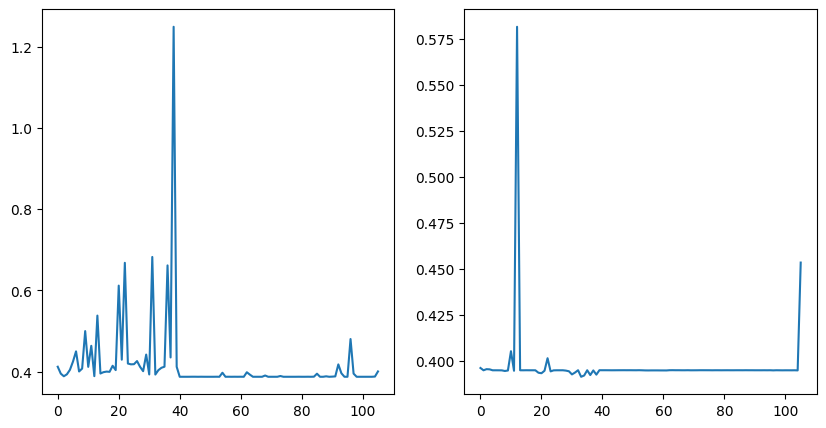

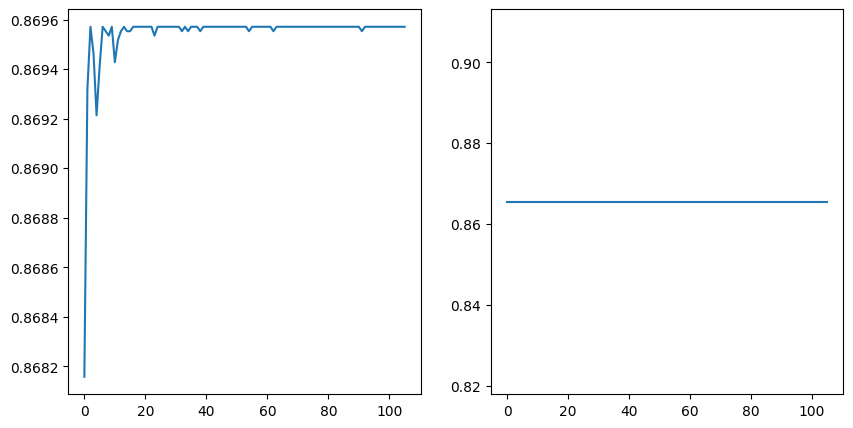

In [53]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'] + history2.history['loss'] + history4.history['loss'])	

plt.subplot(1, 2, 2)
# Plotting hte validation loss
plt.plot( history.history['val_loss'] + history2.history['val_loss'] + history4.history['val_loss'])
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# Ploting the accuracy
plt.plot( history.history['accuracy'] + history2.history['accuracy'] + history4.history['accuracy'])


plt.subplot(1, 2, 2)
# Plotting the validation accuracy
plt.plot( history.history['val_accuracy'] + history2.history['val_accuracy'] + history4.history['val_accuracy'])
plt.show()


# Getting the recall

In [56]:
# Get the actual targets
y_true = np.concatenate([y for x, y in cv_dataset], axis=0)

# Get the model's predictions
y_pred = model.predict(cv_dataset)
y_pred = (y_pred > 0.1).astype(int)  # convert probabilities to class labels

# Calculate recall
recall = tf.keras.metrics.Recall()
recall.update_state(y_true, y_pred)
recall = recall.result().numpy()

print('Recall: ', recall) # 

      5/Unknown 0s 33ms/step

2024-04-24 01:02:58.608791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1921/1921 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


2024-04-24 01:03:06.750699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Recall:  0.99031943


In [57]:
# Get the actual targets
y_true = np.concatenate([y for x, y in cv_dataset], axis=0)

# Get the model's predictions
y_pred = model.predict(cv_dataset)
y_pred = (y_pred > 0.1).astype(int)  # convert probabilities to class labels

# Calculate accuracy
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(y_true, y_pred)
accuracy = accuracy.result().numpy()

print('Accuracy: ', accuracy)

      3/Unknown 0s 27ms/step

2024-04-24 01:04:59.498090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1921/1921 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


2024-04-24 01:05:07.825931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Accuracy:  0.14149961


In [ ]:
# load the best model 
# model.load_weights('best_model.keras')
# loss_value , accuracy = model.evaluate(cv_dataset)

# Testing Googles Model

In [60]:
# google 
def inception_module(x, filters):
    # Each branch of the inception module
    branch1x1 = layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    branch3x3 = layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    branch3x3 = layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu')(branch3x3)

    branch5x5 = layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    branch5x5 = layers.Conv2D(filters[4], (5, 5), padding='same', activation='relu')(branch5x5)

    branch_pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = layers.Conv2D(filters[5], (1, 1), padding='same', activation='relu')(branch_pool)

    # Concatenate all the branches
    output = layers.concatenate([branch1x1, branch3x3, branch5x5, branch_pool], axis=-1)
    return output

def create_googlenet_binary():
    input_layer = layers.Input(shape=(299, 299, 1))

    # Initial Convolution and MaxPooling layers
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # First set of Inception modules
    x = inception_module(x, [64, 96, 128, 16, 32, 32])  # Inception module 1
    x = inception_module(x, [128, 128, 192, 32, 96, 64]) # Inception module 2
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Second set of Inception modules
    x = inception_module(x, [192, 96, 208, 16, 48, 64])  # Inception module 3
    # Add more inception modules as needed
    
    # Ending layers, assuming an average pooling followed by a dropout and a fully connected layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1, activation='sigmoid')(x)  # Use sigmoid activation for binary classification

    model = models.Model(inputs=input_layer, outputs=x)
    return model

# Create the GoogleNet model for binary classification
model_g = create_googlenet_binary()
model_g.summary()


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 150, 150,  │      3,200 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 75, 75,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        256 │ max_pooling2d_12… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 75, 75,    │      6,240 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 75, 75,    │      1,040 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 75, 75,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 75, 75,    │      4,160 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 75, 75,    │    110,720 │ conv2d_28[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 75, 75,    │     12,832 │ conv2d_30[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 75, 75,    │      2,080 │ max_pooling2d_13… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 75, 75,    │          0 │ conv2d_27[0][0],  │
│ (Concatenate)       │ 256)              │            │ conv2d_29[0][0],  │
│                     │                   │            │ conv2d_31[0][0],  │
│                     │                   │            │ conv2d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 75, 75,    │     32,896 │ concatenate_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 75, 75,    │      8,224 │ concatenate_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 75, 75,    │          0 │ concatenate_3[0]… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 75, 75,    │     32,896 │ concatenate_3[0]… │
│                     │ 128)              │            │                 

 Total params: 905,953 (3.46 MB)

 Trainable params: 905,825 (3.46 MB)

 Non-trainable params: 128 (512.00 B)

In [61]:
from keras.callbacks import ModelCheckpoint


model_g.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Recall()])
checkpoint_g = ModelCheckpoint('./best_model_goog.weights.h5', monitor='val_recall', save_best_only=True, save_weights_only=True)
history_g = model_g.fit(train_dataset, validation_data=cv_dataset, epochs=50, callbacks=[checkpoint_g])


Epoch 1/50
   1746/Unknown 276s 136ms/step - accuracy: 0.8638 - loss: 0.3277 - recall_3: 0.0714

2024-04-24 01:27:59.112151: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


   1747/Unknown 293s 146ms/step - accuracy: 0.8638 - loss: 0.3277 - recall_3: 0.0714

2024-04-24 01:28:12.607082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 01:28:12.607216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 01:28:12.607242: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 01:28:12.607289: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, trac

1747/1747 ━━━━━━━━━━━━━━━━━━━━ 305s 153ms/step - accuracy: 0.8638 - loss: 0.3277 - recall_3: 0.0715 - val_accuracy: 0.8663 - val_loss: 0.4359 - val_recall_3: 0.0106
Epoch 2/50


2024-04-24 01:28:24.337489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 01:28:24.337581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_recall available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8755 - loss: 0.2818 - recall_3: 0.1482

2024-04-24 01:32:35.027996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 01:32:35.028100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 259s 148ms/step - accuracy: 0.8755 - loss: 0.2818 - recall_3: 0.1482 - val_accuracy: 0.8703 - val_loss: 0.5203 - val_recall_3: 0.0387
Epoch 3/50


2024-04-24 01:32:43.339580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 01:32:43.339669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8841 - loss: 0.2620 - recall_3: 0.2153

2024-04-24 01:36:31.248807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 01:36:31.248956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 236s 135ms/step - accuracy: 0.8841 - loss: 0.2620 - recall_3: 0.2153 - val_accuracy: 0.8844 - val_loss: 0.2771 - val_recall_3: 0.1500
Epoch 4/50


2024-04-24 01:36:39.527263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 01:36:39.527330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8911 - loss: 0.2495 - recall_3: 0.2808

2024-04-24 01:40:26.393954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 01:40:26.394014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 01:40:26.394028: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 01:40:26.394064: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 235s 134ms/step - accuracy: 0.8911 - loss: 0.2495 - recall_3: 0.2808 - val_accuracy: 0.8698 - val_loss: 0.9909 - val_recall_3: 0.0329
Epoch 5/50


2024-04-24 01:40:34.589998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 01:40:34.590218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 01:40:34.590310: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 01:40:34.590379: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8939 - loss: 0.2494 - recall_3: 0.3050

2024-04-24 01:44:19.750404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 01:44:19.750460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 01:44:19.750475: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 01:44:19.750485: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 233s 133ms/step - accuracy: 0.8939 - loss: 0.2494 - recall_3: 0.3050 - val_accuracy: 0.8645 - val_loss: 0.2981 - val_recall_3: 0.7009
Epoch 6/50


2024-04-24 01:44:27.925695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 01:44:27.925763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 01:44:27.925779: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 01:44:27.925815: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9001 - loss: 0.2359 - recall_3: 0.3699

2024-04-24 01:48:13.297343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 01:48:13.297415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 234s 134ms/step - accuracy: 0.9001 - loss: 0.2359 - recall_3: 0.3699 - val_accuracy: 0.8957 - val_loss: 0.2565 - val_recall_3: 0.6931
Epoch 7/50


2024-04-24 01:48:21.617604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 01:48:21.617679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9022 - loss: 0.2266 - recall_3: 0.3946

2024-04-24 01:52:18.732670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 01:52:18.732746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 246s 141ms/step - accuracy: 0.9022 - loss: 0.2266 - recall_3: 0.3946 - val_accuracy: 0.8916 - val_loss: 0.3070 - val_recall_3: 0.2043
Epoch 8/50


2024-04-24 01:52:27.603455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 01:52:27.603521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 01:52:27.603537: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 01:52:27.603573: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9042 - loss: 0.2228 - recall_3: 0.4156

2024-04-24 01:56:33.455280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 01:56:33.455572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 256s 146ms/step - accuracy: 0.9043 - loss: 0.2228 - recall_3: 0.4156 - val_accuracy: 0.9193 - val_loss: 0.2039 - val_recall_3: 0.4618
Epoch 9/50


2024-04-24 01:56:43.206263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 01:56:43.206342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9093 - loss: 0.2145 - recall_3: 0.4369

2024-04-24 02:01:34.523519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:01:34.523583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 02:01:34.523601: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 02:01:34.523644: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 301s 172ms/step - accuracy: 0.9093 - loss: 0.2145 - recall_3: 0.4369 - val_accuracy: 0.9180 - val_loss: 0.2191 - val_recall_3: 0.6786
Epoch 10/50


2024-04-24 02:01:44.225029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:01:44.225149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9122 - loss: 0.2112 - recall_3: 0.4546

2024-04-24 02:06:04.232528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:06:04.232615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 269s 154ms/step - accuracy: 0.9122 - loss: 0.2112 - recall_3: 0.4546 - val_accuracy: 0.8864 - val_loss: 0.2721 - val_recall_3: 0.1646
Epoch 11/50


2024-04-24 02:06:13.707606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-24 02:06:13.707680: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290
2024-04-24 02:06:13.707695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9156 - loss: 0.2035 - recall_3: 0.4883

2024-04-24 02:10:20.142263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-24 02:10:20.142384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 255s 146ms/step - accuracy: 0.9156 - loss: 0.2035 - recall_3: 0.4883 - val_accuracy: 0.9168 - val_loss: 0.2274 - val_recall_3: 0.4366
Epoch 12/50


2024-04-24 02:10:28.545193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:10:28.545248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 02:10:28.545262: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 02:10:28.545294: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9168 - loss: 0.2012 - recall_3: 0.4953

2024-04-24 02:14:34.259214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 02:14:34.259290: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 02:14:34.259330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 256s 146ms/step - accuracy: 0.9168 - loss: 0.2012 - recall_3: 0.4953 - val_accuracy: 0.8884 - val_loss: 0.2940 - val_recall_3: 0.1820
Epoch 13/50


2024-04-24 02:14:44.264575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:14:44.264663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9203 - loss: 0.1954 - recall_3: 0.5134

2024-04-24 02:18:47.292537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:18:47.292637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 02:18:47.292652: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 02:18:47.292687: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 251s 144ms/step - accuracy: 0.9203 - loss: 0.1954 - recall_3: 0.5134 - val_accuracy: 0.8796 - val_loss: 0.3138 - val_recall_3: 0.7803
Epoch 14/50


2024-04-24 02:18:55.638497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:18:55.638557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 02:18:55.638572: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 02:18:55.638605: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9189 - loss: 0.1951 - recall_3: 0.5141

2024-04-24 02:22:54.740186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:22:54.740241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 02:22:54.740255: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 02:22:54.740291: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 247s 141ms/step - accuracy: 0.9189 - loss: 0.1951 - recall_3: 0.5141 - val_accuracy: 0.9218 - val_loss: 0.1918 - val_recall_3: 0.4714
Epoch 15/50


2024-04-24 02:23:03.043831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:23:03.043897: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290
2024-04-24 02:23:03.043934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9195 - loss: 0.1922 - recall_3: 0.5148

2024-04-24 02:27:03.266644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:27:03.266836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 02:27:03.266910: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 02:27:03.266952: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 250s 143ms/step - accuracy: 0.9195 - loss: 0.1922 - recall_3: 0.5148 - val_accuracy: 0.9301 - val_loss: 0.1760 - val_recall_3: 0.5537
Epoch 16/50


2024-04-24 02:27:12.649953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:27:12.650037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9247 - loss: 0.1853 - recall_3: 0.5462

2024-04-24 02:31:04.477632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:31:04.477695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 02:31:04.477805: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 02:31:04.477845: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 240s 137ms/step - accuracy: 0.9247 - loss: 0.1853 - recall_3: 0.5462 - val_accuracy: 0.9306 - val_loss: 0.1919 - val_recall_3: 0.5857
Epoch 17/50


2024-04-24 02:31:12.760256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:31:12.760334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 02:31:12.760351: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 02:31:12.760392: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9249 - loss: 0.1819 - recall_3: 0.5549

2024-04-24 02:35:01.109965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:35:01.110019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 02:35:01.110126: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 02:35:01.110166: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 237s 135ms/step - accuracy: 0.9249 - loss: 0.1819 - recall_3: 0.5549 - val_accuracy: 0.9344 - val_loss: 0.1702 - val_recall_3: 0.6254
Epoch 18/50


2024-04-24 02:35:09.529423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:35:09.529500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9276 - loss: 0.1803 - recall_3: 0.5682

2024-04-24 02:39:05.005984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:39:05.006072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 02:39:05.006088: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 02:39:05.006122: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 244s 139ms/step - accuracy: 0.9276 - loss: 0.1803 - recall_3: 0.5682 - val_accuracy: 0.9284 - val_loss: 0.1833 - val_recall_3: 0.5460
Epoch 19/50


2024-04-24 02:39:13.226945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:39:13.227030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9283 - loss: 0.1740 - recall_3: 0.5800

2024-04-24 02:43:14.875896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:43:14.875980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 250s 143ms/step - accuracy: 0.9283 - loss: 0.1740 - recall_3: 0.5800 - val_accuracy: 0.8821 - val_loss: 0.5161 - val_recall_3: 0.1568
Epoch 20/50


2024-04-24 02:43:23.617639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-24 02:43:23.617817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:43:23.617891: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9271 - loss: 0.1834 - recall_3: 0.5680

2024-04-24 02:47:13.341108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:47:13.341191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 238s 136ms/step - accuracy: 0.9271 - loss: 0.1834 - recall_3: 0.5680 - val_accuracy: 0.9201 - val_loss: 0.2020 - val_recall_3: 0.6612
Epoch 21/50


2024-04-24 02:47:21.590520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-24 02:47:21.590598: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290
2024-04-24 02:47:21.590632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9302 - loss: 0.1707 - recall_3: 0.5921

2024-04-24 02:51:15.428985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:51:15.429038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 02:51:15.429052: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 02:51:15.429087: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 242s 138ms/step - accuracy: 0.9302 - loss: 0.1707 - recall_3: 0.5921 - val_accuracy: 0.9029 - val_loss: 0.2472 - val_recall_3: 0.7686
Epoch 22/50


2024-04-24 02:51:23.721177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:51:23.721283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9339 - loss: 0.1619 - recall_3: 0.6182

2024-04-24 02:55:11.329633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:55:11.329687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 02:55:11.329702: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 02:55:11.329735: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 236s 135ms/step - accuracy: 0.9339 - loss: 0.1619 - recall_3: 0.6182 - val_accuracy: 0.9190 - val_loss: 0.2331 - val_recall_3: 0.4250
Epoch 23/50


2024-04-24 02:55:19.559872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:55:19.559937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 02:55:19.559954: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 02:55:19.559991: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9341 - loss: 0.1625 - recall_3: 0.6187

2024-04-24 02:59:06.123556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:59:06.123613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 02:59:06.123627: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 02:59:06.123636: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 235s 134ms/step - accuracy: 0.9341 - loss: 0.1625 - recall_3: 0.6187 - val_accuracy: 0.6782 - val_loss: 0.7265 - val_recall_3: 0.6360
Epoch 24/50


2024-04-24 02:59:14.326804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 02:59:14.326857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 02:59:14.326872: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 02:59:14.326901: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9366 - loss: 0.1566 - recall_3: 0.6298

2024-04-24 03:02:59.354781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:02:59.354856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 233s 133ms/step - accuracy: 0.9366 - loss: 0.1566 - recall_3: 0.6298 - val_accuracy: 0.9284 - val_loss: 0.1865 - val_recall_3: 0.4947
Epoch 25/50


2024-04-24 03:03:07.520821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:03:07.520946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 03:03:07.520964: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 03:03:07.520997: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9369 - loss: 0.1566 - recall_3: 0.6346

2024-04-24 03:06:53.236631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:06:53.236701: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 03:06:53.236739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 234s 134ms/step - accuracy: 0.9369 - loss: 0.1566 - recall_3: 0.6346 - val_accuracy: 0.7670 - val_loss: 0.5213 - val_recall_3: 0.5595
Epoch 26/50


2024-04-24 03:07:01.418680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:07:01.418737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 03:07:01.419125: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 03:07:01.419166: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9379 - loss: 0.1548 - recall_3: 0.6399

2024-04-24 03:10:46.208406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:10:46.208479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-24 03:10:54.358092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:10:54.358161: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290
2024-04-24 03:10:54.358195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 235s 134ms/step - accuracy: 0.9379 - loss: 0.1548 - recall_3: 0.6399 - val_accuracy: 0.9163 - val_loss: 0.2188 - val_recall_3: 0.6718
Epoch 27/50
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9385 - loss: 0.1630 - recall_3: 0.6446

2024-04-24 03:14:42.347559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:14:42.347616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 03:14:42.347632: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 03:14:42.347668: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 234s 134ms/step - accuracy: 0.9385 - loss: 0.1630 - recall_3: 0.6446 - val_accuracy: 0.9284 - val_loss: 0.1875 - val_recall_3: 0.6583
Epoch 28/50


2024-04-24 03:14:50.565473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:14:50.565524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 03:14:50.565539: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 03:14:50.565569: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9228 - loss: 0.1900 - recall_3: 0.5435

2024-04-24 03:18:35.710005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:18:35.710048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 03:18:35.710063: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 03:18:35.710073: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 233s 133ms/step - accuracy: 0.9228 - loss: 0.1900 - recall_3: 0.5435 - val_accuracy: 0.9129 - val_loss: 0.2214 - val_recall_3: 0.5557
Epoch 29/50


2024-04-24 03:18:43.908351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:18:43.908427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9419 - loss: 0.1465 - recall_3: 0.6664

2024-04-24 03:22:40.985082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:22:40.985144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 03:22:40.985161: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 03:22:40.985239: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 245s 140ms/step - accuracy: 0.9419 - loss: 0.1465 - recall_3: 0.6664 - val_accuracy: 0.9280 - val_loss: 0.1909 - val_recall_3: 0.5721
Epoch 30/50


2024-04-24 03:22:49.303856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:22:49.303947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9407 - loss: 0.1486 - recall_3: 0.6630

2024-04-24 03:26:38.073462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:26:38.073681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 237s 135ms/step - accuracy: 0.9407 - loss: 0.1486 - recall_3: 0.6630 - val_accuracy: 0.9237 - val_loss: 0.2153 - val_recall_3: 0.6350
Epoch 31/50


2024-04-24 03:26:46.260905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:26:46.260960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 03:26:46.260976: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 03:26:46.261008: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9388 - loss: 0.1517 - recall_3: 0.6459

2024-04-24 03:30:31.240087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:30:31.240162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 233s 133ms/step - accuracy: 0.9388 - loss: 0.1517 - recall_3: 0.6460 - val_accuracy: 0.9268 - val_loss: 0.1950 - val_recall_3: 0.6525
Epoch 32/50


2024-04-24 03:30:39.401871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:30:39.401949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9447 - loss: 0.1387 - recall_3: 0.6845

2024-04-24 03:34:24.563674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:34:24.563808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 03:34:24.563827: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 03:34:24.563864: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 233s 133ms/step - accuracy: 0.9447 - loss: 0.1387 - recall_3: 0.6845 - val_accuracy: 0.8986 - val_loss: 0.4510 - val_recall_3: 0.3330
Epoch 33/50


2024-04-24 03:34:32.718910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:34:32.718986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9433 - loss: 0.1441 - recall_3: 0.6787

2024-04-24 03:38:17.816129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 03:38:17.816204: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 03:38:17.816246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 233s 133ms/step - accuracy: 0.9433 - loss: 0.1441 - recall_3: 0.6787 - val_accuracy: 0.9396 - val_loss: 0.1746 - val_recall_3: 0.6873
Epoch 34/50


2024-04-24 03:38:25.966524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:38:25.966888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 03:38:25.966904: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 03:38:25.966934: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9486 - loss: 0.1297 - recall_3: 0.7138

2024-04-24 03:42:10.657097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:42:10.657147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 03:42:10.657161: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 03:42:10.657193: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 233s 133ms/step - accuracy: 0.9486 - loss: 0.1297 - recall_3: 0.7138 - val_accuracy: 0.9289 - val_loss: 0.1853 - val_recall_3: 0.6834
Epoch 35/50


2024-04-24 03:42:18.795302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:42:18.795386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 03:42:18.795405: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 03:42:18.795447: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9488 - loss: 0.1338 - recall_3: 0.7103

2024-04-24 03:46:03.391926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:46:03.391988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 03:46:03.392002: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 03:46:03.392040: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 233s 133ms/step - accuracy: 0.9488 - loss: 0.1338 - recall_3: 0.7103 - val_accuracy: 0.9371 - val_loss: 0.1774 - val_recall_3: 0.6438
Epoch 36/50


2024-04-24 03:46:11.550116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:46:11.550169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 03:46:11.550236: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 03:46:11.550273: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9500 - loss: 0.1264 - recall_3: 0.7210

2024-04-24 03:49:56.333557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:49:56.333637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 233s 133ms/step - accuracy: 0.9500 - loss: 0.1264 - recall_3: 0.7210 - val_accuracy: 0.9179 - val_loss: 0.2913 - val_recall_3: 0.5818
Epoch 37/50


2024-04-24 03:50:04.494773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 03:50:04.494921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9521 - loss: 0.1223 - recall_3: 0.7316

2024-04-24 03:53:58.595419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:53:58.595525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 244s 140ms/step - accuracy: 0.9521 - loss: 0.1223 - recall_3: 0.7316 - val_accuracy: 0.9153 - val_loss: 0.2594 - val_recall_3: 0.6070
Epoch 38/50


2024-04-24 03:54:08.691165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:54:08.691361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 03:54:08.691389: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 03:54:08.691428: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9548 - loss: 0.1165 - recall_3: 0.7448

2024-04-24 03:58:44.259242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:58:44.259317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 03:58:44.259335: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 03:58:44.259346: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 284s 162ms/step - accuracy: 0.9548 - loss: 0.1165 - recall_3: 0.7448 - val_accuracy: 0.9298 - val_loss: 0.2546 - val_recall_3: 0.5411
Epoch 39/50


2024-04-24 03:58:52.944100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 03:58:52.944196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9543 - loss: 0.1193 - recall_3: 0.7456

2024-04-24 04:02:52.317489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:02:52.317552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 04:02:52.317636: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 04:02:52.317676: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 248s 142ms/step - accuracy: 0.9543 - loss: 0.1193 - recall_3: 0.7456 - val_accuracy: 0.9391 - val_loss: 0.1665 - val_recall_3: 0.6786
Epoch 40/50


2024-04-24 04:03:00.600941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:03:00.601025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 04:03:00.601041: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 04:03:00.601076: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9557 - loss: 0.1151 - recall_3: 0.7532

2024-04-24 04:07:01.989456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:07:01.989530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 250s 143ms/step - accuracy: 0.9557 - loss: 0.1150 - recall_3: 0.7532 - val_accuracy: 0.9145 - val_loss: 0.2408 - val_recall_3: 0.6815
Epoch 41/50


2024-04-24 04:07:10.782089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:07:10.782169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9572 - loss: 0.1123 - recall_3: 0.7617

2024-04-24 04:11:18.180305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:11:18.180402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 257s 147ms/step - accuracy: 0.9572 - loss: 0.1123 - recall_3: 0.7617 - val_accuracy: 0.9397 - val_loss: 0.1961 - val_recall_3: 0.6118
Epoch 42/50


2024-04-24 04:11:27.336755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:11:27.336846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9591 - loss: 0.1097 - recall_3: 0.7719

2024-04-24 04:15:27.713751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:15:27.713853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 249s 143ms/step - accuracy: 0.9591 - loss: 0.1097 - recall_3: 0.7719 - val_accuracy: 0.9358 - val_loss: 0.2172 - val_recall_3: 0.5653
Epoch 43/50


2024-04-24 04:15:36.837211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:15:36.837265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9614 - loss: 0.1041 - recall_3: 0.7855

2024-04-24 04:19:47.104178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:19:47.104294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 260s 149ms/step - accuracy: 0.9614 - loss: 0.1041 - recall_3: 0.7855 - val_accuracy: 0.9218 - val_loss: 0.3574 - val_recall_3: 0.4947
Epoch 44/50


2024-04-24 04:19:57.192538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:19:57.192624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9609 - loss: 0.1037 - recall_3: 0.7854

2024-04-24 04:24:12.607126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:24:12.607194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 04:24:12.607215: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 04:24:12.607254: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 265s 152ms/step - accuracy: 0.9609 - loss: 0.1037 - recall_3: 0.7854 - val_accuracy: 0.9302 - val_loss: 0.2544 - val_recall_3: 0.6263
Epoch 45/50


2024-04-24 04:24:22.631976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-24 04:24:22.632099: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290
2024-04-24 04:24:22.632139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9599 - loss: 0.1059 - recall_3: 0.7819

2024-04-24 04:29:19.679903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:29:19.680284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 04:29:19.680324: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 04:29:19.680393: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 308s 176ms/step - accuracy: 0.9599 - loss: 0.1059 - recall_3: 0.7819 - val_accuracy: 0.9399 - val_loss: 0.1955 - val_recall_3: 0.6641
Epoch 46/50


2024-04-24 04:29:30.847577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:29:30.847631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9629 - loss: 0.1008 - recall_3: 0.7984

2024-04-24 04:33:36.617111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:33:36.617168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 04:33:36.617296: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 04:33:36.617340: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 254s 145ms/step - accuracy: 0.9629 - loss: 0.1008 - recall_3: 0.7984 - val_accuracy: 0.9449 - val_loss: 0.1613 - val_recall_3: 0.6544
Epoch 47/50


2024-04-24 04:33:44.938320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:33:44.938427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 04:33:44.938502: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 04:33:44.938575: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9643 - loss: 0.0938 - recall_3: 0.8052

2024-04-24 04:37:34.000569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:37:34.000682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 237s 136ms/step - accuracy: 0.9643 - loss: 0.0938 - recall_3: 0.8052 - val_accuracy: 0.9373 - val_loss: 0.2098 - val_recall_3: 0.5895
Epoch 48/50


2024-04-24 04:37:42.327929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:37:42.327986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 04:37:42.328001: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 04:37:42.328033: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9661 - loss: 0.0910 - recall_3: 0.8128

2024-04-24 04:41:28.993745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:41:28.993800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 04:41:28.993815: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 04:41:28.993851: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 235s 134ms/step - accuracy: 0.9661 - loss: 0.0910 - recall_3: 0.8128 - val_accuracy: 0.9408 - val_loss: 0.1836 - val_recall_3: 0.7299
Epoch 49/50


2024-04-24 04:41:37.168163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:41:37.168324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 04:41:37.168701: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 04:41:37.168743: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9650 - loss: 0.0934 - recall_3: 0.8106

2024-04-24 04:45:22.148786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:45:22.148942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 233s 133ms/step - accuracy: 0.9650 - loss: 0.0934 - recall_3: 0.8106 - val_accuracy: 0.9153 - val_loss: 0.2033 - val_recall_3: 0.8006
Epoch 50/50


2024-04-24 04:45:30.302554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:45:30.302609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 04:45:30.302622: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 04:45:30.302653: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9675 - loss: 0.0855 - recall_3: 0.8224

2024-04-24 04:49:15.305495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:49:15.305609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 233s 133ms/step - accuracy: 0.9675 - loss: 0.0855 - recall_3: 0.8224 - val_accuracy: 0.9389 - val_loss: 0.2106 - val_recall_3: 0.6467


2024-04-24 04:49:23.466698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 04:49:23.466789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


In [63]:
model_g.save('model_g.keras')

In [64]:
model_g.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Recall()])
checkpoint_g = ModelCheckpoint('./best_model_goog.keras', monitor='val_loss', save_best_only=True)
history_g_2 = model_g.fit(train_dataset, validation_data=cv_dataset, epochs=50, callbacks=[checkpoint_g])


Epoch 1/50
   1747/Unknown 255s 138ms/step - accuracy: 0.9673 - loss: 0.0939 - recall_4: 0.8187

2024-04-24 05:04:14.574757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:04:14.574849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 265s 143ms/step - accuracy: 0.9673 - loss: 0.0939 - recall_4: 0.8187 - val_accuracy: 0.9348 - val_loss: 0.2248 - val_recall_4: 0.6486
Epoch 2/50


2024-04-24 05:04:24.262916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:04:24.263029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 05:04:24.263046: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 05:04:24.263082: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9702 - loss: 0.0814 - recall_4: 0.8339

2024-04-24 05:08:23.601727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:08:23.601785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 05:08:23.601806: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 05:08:23.601843: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 248s 142ms/step - accuracy: 0.9702 - loss: 0.0814 - recall_4: 0.8339 - val_accuracy: 0.8595 - val_loss: 0.3913 - val_recall_4: 0.7057
Epoch 3/50


2024-04-24 05:08:32.724354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-24 05:08:32.724439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9685 - loss: 0.0830 - recall_4: 0.8334

2024-04-24 05:12:37.471815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:12:37.471917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-24 05:12:46.570863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:12:46.570949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 254s 145ms/step - accuracy: 0.9685 - loss: 0.0830 - recall_4: 0.8334 - val_accuracy: 0.9447 - val_loss: 0.1939 - val_recall_4: 0.7599
Epoch 4/50
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9695 - loss: 0.0796 - recall_4: 0.8418

2024-04-24 05:16:58.967835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:16:58.967924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 05:16:58.968044: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 262s 150ms/step - accuracy: 0.9695 - loss: 0.0796 - recall_4: 0.8418 - val_accuracy: 0.9427 - val_loss: 0.1921 - val_recall_4: 0.6583
Epoch 5/50


2024-04-24 05:17:08.310156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:17:08.310250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9723 - loss: 0.0775 - recall_4: 0.8527

2024-04-24 05:21:11.691362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:21:11.691499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 251s 144ms/step - accuracy: 0.9723 - loss: 0.0775 - recall_4: 0.8527 - val_accuracy: 0.9111 - val_loss: 0.3350 - val_recall_4: 0.7318
Epoch 6/50


2024-04-24 05:21:19.920551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:21:19.920634: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 05:21:19.920681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9721 - loss: 0.0771 - recall_4: 0.8550

2024-04-24 05:25:16.635826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:25:16.635953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 246s 140ms/step - accuracy: 0.9721 - loss: 0.0771 - recall_4: 0.8550 - val_accuracy: 0.9330 - val_loss: 0.2937 - val_recall_4: 0.5547
Epoch 7/50


2024-04-24 05:25:25.635192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:25:25.635269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9711 - loss: 0.0777 - recall_4: 0.8495

2024-04-24 05:29:44.186008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:29:44.186310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 269s 154ms/step - accuracy: 0.9711 - loss: 0.0777 - recall_4: 0.8495 - val_accuracy: 0.9112 - val_loss: 0.2826 - val_recall_4: 0.6312
Epoch 8/50


2024-04-24 05:29:54.250398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:29:54.250482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 05:29:54.250497: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 05:29:54.250530: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9752 - loss: 0.0681 - recall_4: 0.8657

2024-04-24 05:34:04.861720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:34:04.861902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 260s 149ms/step - accuracy: 0.9752 - loss: 0.0681 - recall_4: 0.8657 - val_accuracy: 0.9396 - val_loss: 0.2056 - val_recall_4: 0.7561
Epoch 9/50


2024-04-24 05:34:14.267211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:34:14.267296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9730 - loss: 0.0752 - recall_4: 0.8561

2024-04-24 05:38:17.467353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:38:17.467433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 252s 144ms/step - accuracy: 0.9730 - loss: 0.0752 - recall_4: 0.8561 - val_accuracy: 0.9391 - val_loss: 0.2507 - val_recall_4: 0.6176
Epoch 10/50


2024-04-24 05:38:26.729584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:38:26.729673: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 05:38:26.729688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9760 - loss: 0.0646 - recall_4: 0.8726

2024-04-24 05:42:36.806491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:42:36.806593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 260s 148ms/step - accuracy: 0.9760 - loss: 0.0646 - recall_4: 0.8726 - val_accuracy: 0.9306 - val_loss: 0.2284 - val_recall_4: 0.7222
Epoch 11/50


2024-04-24 05:42:46.738940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:42:46.739052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 05:42:46.739312: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 05:42:46.739388: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9740 - loss: 0.0740 - recall_4: 0.8587

2024-04-24 05:47:04.873940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:47:04.874016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 268s 153ms/step - accuracy: 0.9740 - loss: 0.0740 - recall_4: 0.8587 - val_accuracy: 0.9176 - val_loss: 0.4464 - val_recall_4: 0.5760
Epoch 12/50


2024-04-24 05:47:14.906441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:47:14.906535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 05:47:14.906573: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 05:47:14.906614: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9716 - loss: 0.0778 - recall_4: 0.8518

2024-04-24 05:51:47.632061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:51:47.632416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 283s 162ms/step - accuracy: 0.9716 - loss: 0.0777 - recall_4: 0.8518 - val_accuracy: 0.9439 - val_loss: 0.1966 - val_recall_4: 0.6709
Epoch 13/50


2024-04-24 05:51:57.672327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:51:57.672383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 05:51:57.672398: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 05:51:57.672431: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9771 - loss: 0.0645 - recall_4: 0.8802

2024-04-24 05:56:20.876718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:56:20.876791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 273s 156ms/step - accuracy: 0.9771 - loss: 0.0645 - recall_4: 0.8802 - val_accuracy: 0.9374 - val_loss: 0.2177 - val_recall_4: 0.7561
Epoch 14/50


2024-04-24 05:56:30.942137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 05:56:30.942291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9754 - loss: 0.0728 - recall_4: 0.8690

2024-04-24 06:01:11.115526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:01:11.115711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 06:01:11.115809: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 06:01:11.115955: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 290s 166ms/step - accuracy: 0.9754 - loss: 0.0728 - recall_4: 0.8690 - val_accuracy: 0.9363 - val_loss: 0.2477 - val_recall_4: 0.5992
Epoch 15/50


2024-04-24 06:01:21.238593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:01:21.238649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 06:01:21.238664: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 06:01:21.238695: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9793 - loss: 0.0599 - recall_4: 0.8892

2024-04-24 06:05:55.491302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:05:55.491418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 285s 163ms/step - accuracy: 0.9793 - loss: 0.0599 - recall_4: 0.8892 - val_accuracy: 0.9365 - val_loss: 0.2937 - val_recall_4: 0.5973
Epoch 16/50


2024-04-24 06:06:06.090425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-24 06:06:06.090542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9784 - loss: 0.0623 - recall_4: 0.8860

2024-04-24 06:10:48.368803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:10:48.368906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 292s 166ms/step - accuracy: 0.9784 - loss: 0.0623 - recall_4: 0.8860 - val_accuracy: 0.9396 - val_loss: 0.2809 - val_recall_4: 0.6447
Epoch 17/50


2024-04-24 06:10:58.005159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:10:58.005246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9767 - loss: 0.0699 - recall_4: 0.8785

2024-04-24 06:15:04.867989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:15:04.868101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 256s 146ms/step - accuracy: 0.9767 - loss: 0.0699 - recall_4: 0.8785 - val_accuracy: 0.9395 - val_loss: 0.2885 - val_recall_4: 0.6922
Epoch 18/50


2024-04-24 06:15:13.639130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:15:13.639190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 06:15:13.639206: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 06:15:13.639242: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9798 - loss: 0.0547 - recall_4: 0.8951

2024-04-24 06:19:16.154833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:19:16.154914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 252s 144ms/step - accuracy: 0.9798 - loss: 0.0547 - recall_4: 0.8951 - val_accuracy: 0.9240 - val_loss: 0.2990 - val_recall_4: 0.7415
Epoch 19/50


2024-04-24 06:19:25.362947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:19:25.363063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 06:19:25.363088: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 06:19:25.363146: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9783 - loss: 0.0574 - recall_4: 0.8910

2024-04-24 06:23:31.253126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:23:31.253233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 255s 145ms/step - accuracy: 0.9783 - loss: 0.0574 - recall_4: 0.8910 - val_accuracy: 0.9399 - val_loss: 0.2347 - val_recall_4: 0.6554
Epoch 20/50


2024-04-24 06:23:40.189583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:23:40.189662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9811 - loss: 0.0531 - recall_4: 0.8960

2024-04-24 06:27:45.801693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:27:45.801773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 255s 145ms/step - accuracy: 0.9811 - loss: 0.0531 - recall_4: 0.8960 - val_accuracy: 0.9354 - val_loss: 0.2571 - val_recall_4: 0.5847
Epoch 21/50


2024-04-24 06:27:54.824848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 06:27:54.824927: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 06:27:54.824964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9795 - loss: 0.0563 - recall_4: 0.8941

2024-04-24 06:31:59.822146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:31:59.822235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 06:31:59.822252: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 06:31:59.822292: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 254s 145ms/step - accuracy: 0.9795 - loss: 0.0563 - recall_4: 0.8941 - val_accuracy: 0.9278 - val_loss: 0.3050 - val_recall_4: 0.6534
Epoch 22/50


2024-04-24 06:32:08.930647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:32:08.930700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 06:32:08.930714: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 06:32:08.930745: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9722 - loss: 0.0989 - recall_4: 0.8558

2024-04-24 06:36:11.970170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:36:11.970238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 06:36:11.970253: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 06:36:11.970290: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 251s 144ms/step - accuracy: 0.9722 - loss: 0.0988 - recall_4: 0.8558 - val_accuracy: 0.7174 - val_loss: 0.9385 - val_recall_4: 0.8325
Epoch 23/50


2024-04-24 06:36:20.311388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:36:20.311461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 06:36:20.311480: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 06:36:20.311518: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9816 - loss: 0.0493 - recall_4: 0.9066

2024-04-24 06:40:17.551892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:40:17.552005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 247s 141ms/step - accuracy: 0.9816 - loss: 0.0494 - recall_4: 0.9066 - val_accuracy: 0.9363 - val_loss: 0.2540 - val_recall_4: 0.6612
Epoch 24/50


2024-04-24 06:40:26.833992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:40:26.834050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 06:40:26.834064: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 06:40:26.834096: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9827 - loss: 0.0464 - recall_4: 0.9128

2024-04-24 06:44:40.296785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:44:40.296909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 264s 151ms/step - accuracy: 0.9827 - loss: 0.0464 - recall_4: 0.9128 - val_accuracy: 0.9336 - val_loss: 0.3586 - val_recall_4: 0.5682
Epoch 25/50


2024-04-24 06:44:50.375625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:44:50.375724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9814 - loss: 0.0578 - recall_4: 0.9040

2024-04-24 06:49:15.767785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:49:15.768100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 275s 157ms/step - accuracy: 0.9814 - loss: 0.0578 - recall_4: 0.9040 - val_accuracy: 0.9262 - val_loss: 0.5356 - val_recall_4: 0.5382
Epoch 26/50


2024-04-24 06:49:25.168979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:49:25.169056: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 06:49:25.169094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9812 - loss: 0.0512 - recall_4: 0.9039

2024-04-24 06:53:35.763131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:53:35.763200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 260s 148ms/step - accuracy: 0.9812 - loss: 0.0512 - recall_4: 0.9039 - val_accuracy: 0.9175 - val_loss: 0.3358 - val_recall_4: 0.7502
Epoch 27/50


2024-04-24 06:53:44.943620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:53:44.943689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 06:53:44.943707: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 06:53:44.943747: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9834 - loss: 0.0468 - recall_4: 0.9138

2024-04-24 06:57:58.192001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:57:58.192070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 263s 150ms/step - accuracy: 0.9834 - loss: 0.0468 - recall_4: 0.9138 - val_accuracy: 0.9326 - val_loss: 0.3103 - val_recall_4: 0.5653
Epoch 28/50


2024-04-24 06:58:07.614033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 06:58:07.614253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9800 - loss: 0.0579 - recall_4: 0.8975

2024-04-24 07:02:44.600460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 07:02:44.600670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 288s 165ms/step - accuracy: 0.9800 - loss: 0.0579 - recall_4: 0.8975 - val_accuracy: 0.9388 - val_loss: 0.2606 - val_recall_4: 0.6757
Epoch 29/50


2024-04-24 07:02:55.828823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 07:02:55.829208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 07:02:55.829276: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 07:02:55.829425: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9842 - loss: 0.0432 - recall_4: 0.9188

2024-04-24 07:08:00.801614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 07:08:00.801707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 316s 180ms/step - accuracy: 0.9842 - loss: 0.0432 - recall_4: 0.9188 - val_accuracy: 0.9374 - val_loss: 0.2507 - val_recall_4: 0.6118
Epoch 30/50


2024-04-24 07:08:11.987467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 07:08:11.987683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9840 - loss: 0.0438 - recall_4: 0.9186

2024-04-24 07:13:17.552053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 07:13:17.552219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 07:13:17.552309: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 07:13:17.552403: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 317s 181ms/step - accuracy: 0.9840 - loss: 0.0438 - recall_4: 0.9186 - val_accuracy: 0.9414 - val_loss: 0.2485 - val_recall_4: 0.7231
Epoch 31/50


2024-04-24 07:13:28.687691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 07:13:28.687802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9848 - loss: 0.0468 - recall_4: 0.9236

2024-04-24 07:19:43.823155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 07:19:43.823268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 391s 223ms/step - accuracy: 0.9848 - loss: 0.0468 - recall_4: 0.9236 - val_accuracy: 0.9266 - val_loss: 0.4208 - val_recall_4: 0.5837
Epoch 32/50


2024-04-24 07:19:59.393750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 07:19:59.393841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9841 - loss: 0.0460 - recall_4: 0.9205

2024-04-24 07:25:50.172575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 07:25:50.172688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 365s 208ms/step - accuracy: 0.9841 - loss: 0.0460 - recall_4: 0.9205 - val_accuracy: 0.9406 - val_loss: 0.2696 - val_recall_4: 0.6534
Epoch 33/50


2024-04-24 07:26:04.029742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 07:26:04.029801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 07:26:04.029817: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 07:26:04.029850: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.9852 - loss: 0.0417 - recall_4: 0.9225

2024-04-24 07:31:44.337151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 07:31:44.337235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 353s 202ms/step - accuracy: 0.9852 - loss: 0.0417 - recall_4: 0.9225 - val_accuracy: 0.9362 - val_loss: 0.3927 - val_recall_4: 0.7183
Epoch 34/50


2024-04-24 07:31:57.207621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 07:31:57.207679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 07:31:57.207695: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 07:31:57.207733: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9858 - loss: 0.0433 - recall_4: 0.9273

2024-04-24 07:37:24.561926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 07:37:24.561994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 07:37:24.562016: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 07:37:24.562056: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 340s 195ms/step - accuracy: 0.9858 - loss: 0.0433 - recall_4: 0.9273 - val_accuracy: 0.9288 - val_loss: 0.4598 - val_recall_4: 0.5653
Epoch 35/50


2024-04-24 07:37:37.423326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 07:37:37.423378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 07:37:37.423393: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 07:37:37.423427: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9842 - loss: 0.0468 - recall_4: 0.9227

2024-04-24 07:43:04.606968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 07:43:04.607047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 340s 194ms/step - accuracy: 0.9842 - loss: 0.0468 - recall_4: 0.9227 - val_accuracy: 0.9413 - val_loss: 0.2881 - val_recall_4: 0.6438
Epoch 36/50


2024-04-24 07:43:17.477368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 07:43:17.477456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9856 - loss: 0.0405 - recall_4: 0.9260

2024-04-24 07:48:44.240914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 07:48:44.241052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 340s 194ms/step - accuracy: 0.9856 - loss: 0.0405 - recall_4: 0.9260 - val_accuracy: 0.9324 - val_loss: 0.3440 - val_recall_4: 0.6234
Epoch 37/50


2024-04-24 07:48:57.090862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 07:48:57.091055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 07:48:57.091080: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 07:48:57.091118: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9873 - loss: 0.0386 - recall_4: 0.9359

2024-04-24 07:54:23.857981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 07:54:23.858247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 341s 195ms/step - accuracy: 0.9873 - loss: 0.0386 - recall_4: 0.9359 - val_accuracy: 0.9149 - val_loss: 0.3406 - val_recall_4: 0.7028
Epoch 38/50


2024-04-24 07:54:37.697991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 07:54:37.698057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 07:54:37.698073: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 07:54:37.698110: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9859 - loss: 0.0406 - recall_4: 0.9307

2024-04-24 08:00:29.640209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 08:00:29.640306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 365s 209ms/step - accuracy: 0.9859 - loss: 0.0406 - recall_4: 0.9307 - val_accuracy: 0.9345 - val_loss: 0.3154 - val_recall_4: 0.5605
Epoch 39/50


2024-04-24 08:00:43.126943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 08:00:43.127059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9865 - loss: 0.0388 - recall_4: 0.9325

2024-04-24 08:06:25.714399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 08:06:25.714575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 356s 203ms/step - accuracy: 0.9865 - loss: 0.0388 - recall_4: 0.9325 - val_accuracy: 0.9284 - val_loss: 0.4132 - val_recall_4: 0.5682
Epoch 40/50


2024-04-24 08:06:39.159810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 08:06:39.159909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 08:06:39.159958: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9842 - loss: 0.0457 - recall_4: 0.9190

2024-04-24 08:12:21.577547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 08:12:21.577687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 356s 203ms/step - accuracy: 0.9842 - loss: 0.0457 - recall_4: 0.9190 - val_accuracy: 0.9005 - val_loss: 0.3630 - val_recall_4: 0.6457
Epoch 41/50


2024-04-24 08:12:35.009875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 08:12:35.009932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 08:12:35.009947: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 08:12:35.009980: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9857 - loss: 0.0462 - recall_4: 0.9273

2024-04-24 08:18:17.174564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 08:18:17.174642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 08:18:17.174660: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 08:18:17.174708: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 356s 203ms/step - accuracy: 0.9857 - loss: 0.0462 - recall_4: 0.9273 - val_accuracy: 0.9343 - val_loss: 0.3060 - val_recall_4: 0.5837
Epoch 42/50


2024-04-24 08:18:30.622823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 08:18:30.622928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 08:18:30.622946: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 08:18:30.622980: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9880 - loss: 0.0373 - recall_4: 0.9420

2024-04-24 08:24:12.653585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 08:24:12.653637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 355s 203ms/step - accuracy: 0.9880 - loss: 0.0373 - recall_4: 0.9420 - val_accuracy: 0.9376 - val_loss: 0.3236 - val_recall_4: 0.6815
Epoch 43/50


2024-04-24 08:24:26.121001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 08:24:26.121063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 08:24:26.121078: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 08:24:26.121112: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9854 - loss: 0.0429 - recall_4: 0.9302

2024-04-24 08:30:08.325113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 08:30:08.325245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 356s 203ms/step - accuracy: 0.9854 - loss: 0.0429 - recall_4: 0.9302 - val_accuracy: 0.9421 - val_loss: 0.3173 - val_recall_4: 0.6883
Epoch 44/50


2024-04-24 08:30:21.799515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 08:30:21.799603: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 08:30:21.799617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9853 - loss: 0.0551 - recall_4: 0.9303

2024-04-24 08:36:03.952869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 08:36:03.953151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 356s 203ms/step - accuracy: 0.9853 - loss: 0.0551 - recall_4: 0.9303 - val_accuracy: 0.9360 - val_loss: 0.3911 - val_recall_4: 0.5712
Epoch 45/50


2024-04-24 08:36:17.410456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 08:36:17.410569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 08:36:17.410618: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 08:36:17.410723: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9864 - loss: 0.0425 - recall_4: 0.9316

2024-04-24 08:41:59.792373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 08:41:59.792514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 356s 203ms/step - accuracy: 0.9864 - loss: 0.0425 - recall_4: 0.9316 - val_accuracy: 0.9430 - val_loss: 0.3798 - val_recall_4: 0.6680
Epoch 46/50


2024-04-24 08:42:13.254392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 08:42:13.254450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 08:42:13.254465: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 08:42:13.254500: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9883 - loss: 0.0384 - recall_4: 0.9421

2024-04-24 08:47:55.710996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 08:47:55.711071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 356s 204ms/step - accuracy: 0.9883 - loss: 0.0384 - recall_4: 0.9421 - val_accuracy: 0.9311 - val_loss: 0.4959 - val_recall_4: 0.7454
Epoch 47/50


2024-04-24 08:48:09.187807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 08:48:09.187873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 08:48:09.187889: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 08:48:09.187925: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9889 - loss: 0.0326 - recall_4: 0.9450

2024-04-24 08:53:51.697007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 08:53:51.697213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 356s 203ms/step - accuracy: 0.9889 - loss: 0.0326 - recall_4: 0.9450 - val_accuracy: 0.9468 - val_loss: 0.3138 - val_recall_4: 0.7299
Epoch 48/50


2024-04-24 08:54:05.162029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 08:54:05.162159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 08:54:05.162179: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 08:54:05.162222: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9873 - loss: 0.0392 - recall_4: 0.9409

2024-04-24 08:59:47.506213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 08:59:47.506321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 356s 203ms/step - accuracy: 0.9873 - loss: 0.0392 - recall_4: 0.9409 - val_accuracy: 0.9430 - val_loss: 0.4332 - val_recall_4: 0.7715
Epoch 49/50


2024-04-24 09:00:00.996653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 09:00:00.996751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9897 - loss: 0.0295 - recall_4: 0.9494

2024-04-24 09:05:43.277974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 09:05:43.278130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 356s 203ms/step - accuracy: 0.9897 - loss: 0.0295 - recall_4: 0.9493 - val_accuracy: 0.9432 - val_loss: 0.3966 - val_recall_4: 0.7348
Epoch 50/50


2024-04-24 09:05:56.700992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 09:05:56.701072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9889 - loss: 0.0341 - recall_4: 0.9457

2024-04-24 09:11:38.847648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 09:11:38.847735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 356s 203ms/step - accuracy: 0.9889 - loss: 0.0341 - recall_4: 0.9457 - val_accuracy: 0.9393 - val_loss: 0.4978 - val_recall_4: 0.6302


2024-04-24 09:11:52.337298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 09:11:52.337368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-24 09:11:52.337383: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14643695325638302765
2024-04-24 09:11:52.337417: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5984272009254812290


In [65]:
model_g.save('model_g.keras')

In [66]:
print(history_g.history)
print(history_g_2.history)

{'accuracy': [0.8682115077972412, 0.8773731589317322, 0.8855149149894714, 0.8915451169013977, 0.8950344324111938, 0.9002952575683594, 0.9041603207588196, 0.9062539339065552, 0.9103516340255737, 0.912552535533905, 0.9154513478279114, 0.915505051612854, 0.9204079508781433, 0.9182965159416199, 0.9213205575942993, 0.9250603914260864, 0.9239867329597473, 0.9269929528236389, 0.9287107586860657, 0.9281202554702759, 0.9299632906913757, 0.933649480342865, 0.93427574634552, 0.936279833316803, 0.9371208548545837, 0.9385166168212891, 0.9389460682868958, 0.9225731492042542, 0.9414869546890259, 0.9395902156829834, 0.942936360836029, 0.945012092590332, 0.9456741809844971, 0.9490203261375427, 0.9487161040306091, 0.9508275985717773, 0.9513643980026245, 0.9546568989753723, 0.9542274475097656, 0.9563388824462891, 0.9585398435592651, 0.956875741481781, 0.9609913229942322, 0.9619039297103882, 0.9583967328071594, 0.9640869498252869, 0.9645164012908936, 0.9663416147232056, 0.9635322690010071, 0.9682204723358

In [74]:
history_g_2.history.keys()


dict_keys(['accuracy', 'loss', 'recall_4', 'val_accuracy', 'val_loss', 'val_recall_4'])

In [94]:
plt.figure(figsize=(13, 8))
plt.subplot(3,2,1)
plt.title('Loss')
plt.plot(history_g.history['loss'] + history_g_2.history['loss'])
plt.subplot(3,2,2)
plt.title('Validation Loss')
plt.plot(history_g.history['val_loss'] + history_g_2.history['val_loss'])

plt.subplot(3,2,3)
plt.title('Accuracy')
plt.plot(history_g.history['accuracy'] + history_g_2.history['accuracy'])
plt.subplot(3,2,4)
plt.title('Validation Accuracy')
plt.plot(history_g.history['val_accuracy'] + history_g_2.history['val_accuracy'])

plt.subplot(3,2,5)
plt.title("recall")
plt.plot(history_g.history['recall_3'] + history_g_2.history['recall_4'])
plt.subplot(3,2,6)
plt.title("Validation Recall")
plt.plot(history_g.history['val_recall_3'] + history_g_2.history['val_recall_4'])

plt.subplots_adjust(hspace=0.3)  # adjust the space between plots
plt.show()

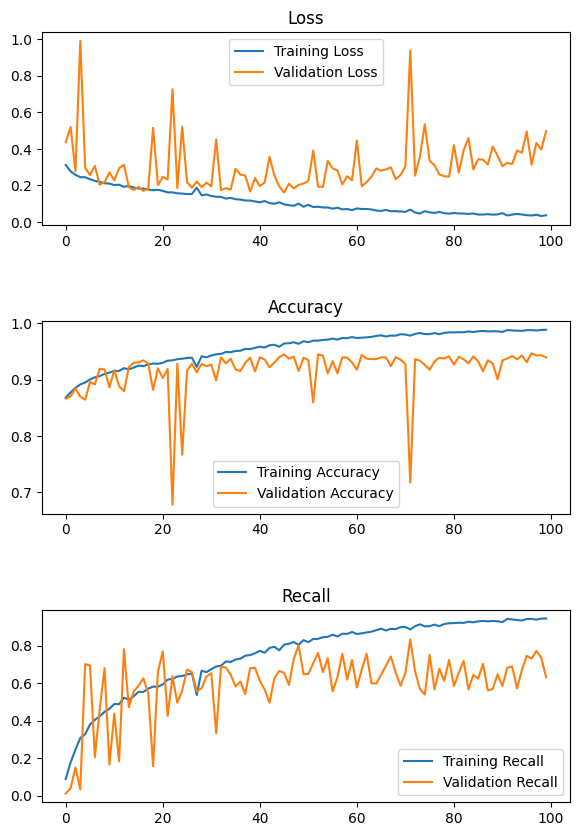

In [104]:
plt.figure(figsize=(15, 10))

plt.subplot(3,2,1)
plt.title('Loss')
plt.plot(history_g.history['loss'] + history_g_2.history['loss'], label='Training Loss')
plt.legend()
plt.plot(history_g.history['val_loss'] + history_g_2.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(3,2,3)
plt.title('Accuracy')
plt.plot(history_g.history['accuracy'] + history_g_2.history['accuracy'], label='Training Accuracy')
plt.legend()
plt.plot(history_g.history['val_accuracy'] + history_g_2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.subplot(3,2,5)
plt.title("Recall")
plt.plot(history_g.history['recall_3'] + history_g_2.history['recall_4'], label='Training Recall')
plt.legend()
plt.plot(history_g.history['val_recall_3'] + history_g_2.history['val_recall_4'], label='Validation Recall')
plt.legend()

plt.subplots_adjust(hspace=0.5)  # adjust the space between plots
plt.show()

In [83]:
loss, accuracy, recall = model_g.evaluate(test_dataset)

print('Test Loss: ', loss)
print('Test Accuracy: ', accuracy)
print('Test Recall: ', recall)

241/241 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.9441 - loss: 0.2879 - recall_4: 0.6543
Test Loss:  0.2892104983329773
Test Accuracy:  0.941291332244873
Test Recall:  0.6343975067138672


2024-04-24 16:00:47.836487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-04-24 16:00:47.836581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Googles model tested at the 100th epoch got a the following metrics 

| Metric   | Value |
|----------|-------|
| Loss     | 0.2892104983329773    |
| Accuracy | 0.941291332244873    |
| Recall   | 0.6343975067138672    |

In [91]:
model_g_best = create_googlenet_binary()
model_g_best.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Recall()])
model_g_best.load_weights("./best_model_goog.keras")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 86 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


THe model with the lowest lost, not necessarly the lowest accuracy or recall 

In [92]:
loss, accuracy, recall = model_g_best.evaluate(test_dataset)

print('Test Loss: ', loss)
print('Test Accuracy: ', accuracy)
print('Test Recall: ', recall)

241/241 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.9487 - loss: 0.1865 - recall_9: 0.6657
Test Loss:  0.1863839030265808
Test Accuracy:  0.9462379813194275
Test Recall:  0.6508753895759583


2024-04-24 16:05:10.779652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 16:05:10.779736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Googles model tested at the best loss  got a the following metrics 

| Metric   | Value |
|----------|-------|
| Loss     | 0.1863839030265808    |
| Accuracy | 0.9462379813194275    |
| Recall   | 0.6508753895759583    |

In [32]:
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Dropout, Dense, Flatten, BatchNormalization, Activation, AveragePooling2D, Add
from keras.models import Model

def inception_module_v3(x, filters):
    # BatchNormalization and Activation layers are applied after each convolution operation
    # 1x1 convolution
    conv1x1 = Conv2D(filters['1x1'], (1, 1), padding='same')(x)
    conv1x1 = BatchNormalization()(conv1x1) # BatchNormalization layer is added
    conv1x1 = Activation('relu')(conv1x1) # ReLU activation function is used

    # Factored 5x5 convolution as two 3x3 convolutions
    conv5x5 = Conv2D(filters['5x5_reduce'], (1, 1), padding='same')(x)
    conv5x5 = BatchNormalization()(conv5x5) # BatchNormalization layer is added
    conv5x5 = Activation('relu')(conv5x5) # ReLU activation function is used
    conv5x5 = Conv2D(filters['5x5'], (3, 3), padding='same')(conv5x5)
    conv5x5 = BatchNormalization()(conv5x5) # BatchNormalization layer is added
    conv5x5 = Activation('relu')(conv5x5) # ReLU activation function is used
    conv5x5 = Conv2D(filters['5x5'], (3, 3), padding='same')(conv5x5)
    conv5x5 = BatchNormalization()(conv5x5) # BatchNormalization layer is added
    conv5x5 = Activation('relu')(conv5x5) # ReLU activation function is used

    # 3x3 convolution
    conv3x3 = Conv2D(filters['3x3_reduce'], (1, 1), padding='same')(x)
    conv3x3 = BatchNormalization()(conv3x3) # BatchNormalization layer is added
    conv3x3 = Activation('relu')(conv3x3) # ReLU activation function is used
    conv3x3 = Conv2D(filters['3x3'], (3, 3), padding='same')(conv3x3)
    conv3x3 = BatchNormalization()(conv3x3) # BatchNormalization layer is added
    conv3x3 = Activation('relu')(conv3x3) # ReLU activation function is used

    # MaxPooling with 1x1 convolution projection
    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters['pool_proj'], (1, 1), padding='same')(pool_proj)
    pool_proj = BatchNormalization()(pool_proj) # BatchNormalization layer is added
    pool_proj = Activation('relu')(pool_proj) # ReLU activation function is used

    # Concatenate all the convolutions
    output = concatenate([conv1x1, conv5x5, conv3x3, pool_proj], axis=-1)
    return output



def googlenet_custom():
    input_layer = Input(shape=(299, 299, 1))

    # Initial Convolution and MaxPooling layer
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    # Initially make less filters 
    x = inception_module(x, filters={'1x1': 64,  
                                '5x5_reduce': 16, '5x5': 48, 
                                '3x3_reduce': 64, '3x3': 96, 
                                'pool_proj': 32
                                    }
                        )
    x = inception_module(x, filters={'1x1': 128, 
                                    '5x5_reduce': 32, '5x5': 96, 
                                    '3x3_reduce': 128, '3x3': 192, 
                                    'pool_proj': 64
                                     }
                         )
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, filters={'1x1': 64,  
                                '5x5_reduce': 16, '5x5': 48, 
                                '3x3_reduce': 64, '3x3': 96, 
                                'pool_proj': 32
                                    }
                        )
    x = inception_module(x, filters={'1x1': 128, 
                                    '5x5_reduce': 32, '5x5': 96, 
                                    '3x3_reduce': 128, '3x3': 192, 
                                    'pool_proj': 64
                                     }
                         )
    
    x = layers.AveragePooling2D((3, 3), strides=(1, 1))(x)  # added average pooling layer, no padding
    x = inception_module(x, filters={'1x1': 64,  
                                '5x5_reduce': 16, '5x5': 48, 
                                '3x3_reduce': 64, '3x3': 96, 
                                'pool_proj': 32
                                    }
                        )
    x = inception_module(x, filters={'1x1': 128, 
                                    '5x5_reduce': 32, '5x5': 96, 
                                    '3x3_reduce': 128, '3x3': 192, 
                                    'pool_proj': 64
                                     }
                         )

    x = layers.AveragePooling2D((3, 3), strides=(1, 1))(x)  # added average pooling layer, no padding
    x = inception_module(x, filters={'1x1': 64,  
                                '5x5_reduce': 16, '5x5': 48, 
                                '3x3_reduce': 64, '3x3': 96, 
                                'pool_proj': 32
                                    }
                        )
    x = inception_module(x, filters={'1x1': 128, 
                                    '5x5_reduce': 32, '5x5': 96, 
                                    '3x3_reduce': 128, '3x3': 192, 
                                    'pool_proj': 64
                                     }
                         )


    # Final layers for classification
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x) # Add fully connected layer is added 
    x = Dropout(0.4)(x) # This dropout is added
    x = layers.Dense(1, activation='sigmoid')(x)  # Use sigmoid activation for binary classification

    model = models.Model(inputs=input_layer, outputs=x)
    return model


In [33]:
from keras.metrics import Recall 
from keras.callbacks import ModelCheckpoint


# Create and compile the model
model_custom = googlenet_custom()
checkpoint_val_loss = ModelCheckpoint('./custom_best_val_loss.keras', monitor='val_loss', save_best_only=True)
check_point_recall = ModelCheckpoint('./custom_best_recall.keras', monitor='recall', save_best_only=True, mode='max')
model_custom.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall(name='recall')])
history = model_custom.fit(train_dataset, validation_data=cv_dataset, epochs=2, callbacks=[checkpoint_val_loss, check_point_recall])


Epoch 1/2


I0000 00:00:1714769552.894488    1270 service.cc:145] XLA service 0x7f2730002eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714769552.895786    1270 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-05-03 20:52:33.880453: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-03 20:52:37.262815: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1714769618.697420    1270 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   1747/Unknown 567s 270ms/step - accuracy: 0.8702 - loss: 0.3010 - recall_1: 0.1756

2024-05-03 21:01:31.305431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 21:01:31.306767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
I0000 00:00:1714770097.582679   94550 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1564', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1714770097.765922   94543 asm_compiler.cc:369] ptxas warning : Registers are spilled to 

1747/1747 ━━━━━━━━━━━━━━━━━━━━ 600s 289ms/step - accuracy: 0.8702 - loss: 0.3010 - recall_1: 0.1757 - val_accuracy: 0.5260 - val_loss: 0.5603 - val_recall_1: 0.5276
Epoch 2/2


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with recall available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.8926 - loss: 0.2452 - recall_1: 0.3891

2024-05-03 21:09:14.170124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 21:09:14.171407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-03 21:09:30.278053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 21:09:30.278826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 446s 255ms/step - accuracy: 0.8926 - loss: 0.2452 - recall_1: 0.3891 - val_accuracy: 0.9013 - val_loss: 0.2321 - val_recall_1: 0.3301


In [34]:
history2 = model_custom.fit(train_dataset, validation_data=cv_dataset, epochs=6, callbacks=[checkpoint_val_loss, check_point_recall])


Epoch 1/6
   1747/Unknown 431s 246ms/step - accuracy: 0.9036 - loss: 0.2260 - recall_1: 0.4636

2024-05-03 21:19:39.658588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 21:19:39.659827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 447s 255ms/step - accuracy: 0.9036 - loss: 0.2260 - recall_1: 0.4637 - val_accuracy: 0.8822 - val_loss: 0.6871 - val_recall_1: 0.1336
Epoch 2/6


2024-05-03 21:19:55.607513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 21:19:55.607691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with recall available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9119 - loss: 0.2093 - recall_1: 0.5221

2024-05-03 21:28:09.187655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 21:28:09.188284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 514s 294ms/step - accuracy: 0.9119 - loss: 0.2093 - recall_1: 0.5221 - val_accuracy: 0.9107 - val_loss: 0.2842 - val_recall_1: 0.3650
Epoch 3/6


2024-05-03 21:28:29.205638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 21:28:29.205729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-03 21:28:29.205769: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9176 - loss: 0.1982 - recall_1: 0.5551

2024-05-03 21:37:05.213251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 21:37:05.214474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 536s 307ms/step - accuracy: 0.9176 - loss: 0.1982 - recall_1: 0.5551 - val_accuracy: 0.9067 - val_loss: 0.2488 - val_recall_1: 0.7444
Epoch 4/6


2024-05-03 21:37:25.146635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 21:37:25.146721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9223 - loss: 0.1894 - recall_1: 0.5768

2024-05-03 21:46:00.484046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 21:46:00.485420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-03 21:46:20.373922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 21:46:20.374004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 536s 307ms/step - accuracy: 0.9223 - loss: 0.1894 - recall_1: 0.5768 - val_accuracy: 0.9089 - val_loss: 0.2088 - val_recall_1: 0.5586
Epoch 5/6
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9262 - loss: 0.1803 - recall_1: 0.6049

2024-05-03 21:54:56.065091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 21:54:56.065632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-03 21:55:16.007178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 21:55:16.007241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 536s 306ms/step - accuracy: 0.9262 - loss: 0.1803 - recall_1: 0.6049 - val_accuracy: 0.9367 - val_loss: 0.1776 - val_recall_1: 0.8219
Epoch 6/6
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9330 - loss: 0.1662 - recall_1: 0.6548

2024-05-03 22:03:25.945445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 22:03:25.947356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 505s 289ms/step - accuracy: 0.9330 - loss: 0.1662 - recall_1: 0.6548 - val_accuracy: 0.9313 - val_loss: 0.1817 - val_recall_1: 0.7299


2024-05-03 22:03:42.113700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 22:03:42.113794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


In [35]:
model_custom.save("custom_model_8.keras")

In [36]:
# model_custom.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall(name='recall')])
history3 = model_custom.fit(train_dataset, validation_data=cv_dataset, epochs=5, callbacks=[checkpoint_val_loss, check_point_recall])


Epoch 1/5
   1747/Unknown 430s 245ms/step - accuracy: 0.9368 - loss: 0.1569 - recall_1: 0.6747

2024-05-03 22:28:19.989778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 22:28:19.991025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 445s 255ms/step - accuracy: 0.9368 - loss: 0.1569 - recall_1: 0.6747 - val_accuracy: 0.8670 - val_loss: 3.6208 - val_recall_1: 0.0174
Epoch 2/5


2024-05-03 22:28:35.843651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 22:28:35.844399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with recall available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9400 - loss: 0.1505 - recall_1: 0.6958

2024-05-03 22:35:44.967341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 22:35:44.967793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 445s 255ms/step - accuracy: 0.9400 - loss: 0.1505 - recall_1: 0.6958 - val_accuracy: 0.9215 - val_loss: 0.2229 - val_recall_1: 0.7725
Epoch 3/5


2024-05-03 22:36:01.039855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 22:36:01.040014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9444 - loss: 0.1402 - recall_1: 0.7231

2024-05-03 22:43:11.391059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 22:43:11.392459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-03 22:43:27.422575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 22:43:27.422633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-03 22:43:27.422702: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-03 22:43:27.422716: I tensorflow/core/framework/local_re

1747/1747 ━━━━━━━━━━━━━━━━━━━━ 447s 256ms/step - accuracy: 0.9444 - loss: 0.1402 - recall_1: 0.7231 - val_accuracy: 0.9408 - val_loss: 0.1652 - val_recall_1: 0.6157
Epoch 4/5
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9458 - loss: 0.1359 - recall_1: 0.7274

2024-05-03 22:50:38.489208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 22:50:38.489902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 446s 255ms/step - accuracy: 0.9458 - loss: 0.1359 - recall_1: 0.7274 - val_accuracy: 0.7786 - val_loss: 0.9300 - val_recall_1: 0.9574
Epoch 5/5


2024-05-03 22:50:54.542535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 22:50:54.542925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9509 - loss: 0.1263 - recall_1: 0.7504

2024-05-03 22:58:09.015715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 22:58:09.016621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 451s 258ms/step - accuracy: 0.9509 - loss: 0.1263 - recall_1: 0.7504 - val_accuracy: 0.9539 - val_loss: 0.1801 - val_recall_1: 0.7793


2024-05-03 22:58:25.091774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 22:58:25.091855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


In [37]:
model_custom.save("custom_model_13.keras")

In [38]:
history4 = model_custom.fit(train_dataset, validation_data=cv_dataset, epochs=8, callbacks=[checkpoint_val_loss, check_point_recall])


Epoch 1/8
   1747/Unknown 433s 248ms/step - accuracy: 0.9536 - loss: 0.1191 - recall_1: 0.7762

2024-05-03 23:27:53.323413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 23:27:53.324189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 450s 257ms/step - accuracy: 0.9536 - loss: 0.1191 - recall_1: 0.7762 - val_accuracy: 0.8992 - val_loss: 0.3789 - val_recall_1: 0.3640
Epoch 2/8


2024-05-03 23:28:09.600982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 23:28:09.601050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-03 23:28:09.601179: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-03 23:28:09.601226: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9430751880462485458
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with recall available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9569 - loss: 0.1141 - recall_1: 0.7874

2024-05-03 23:35:23.267970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 23:35:23.268764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 450s 257ms/step - accuracy: 0.9569 - loss: 0.1141 - recall_1: 0.7874 - val_accuracy: 0.8867 - val_loss: 1.0029 - val_recall_1: 0.2536
Epoch 3/8


2024-05-03 23:35:39.411346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 23:35:39.411429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9579 - loss: 0.1085 - recall_1: 0.7963

2024-05-03 23:42:52.471158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 23:42:52.472389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 449s 257ms/step - accuracy: 0.9579 - loss: 0.1085 - recall_1: 0.7963 - val_accuracy: 0.7108 - val_loss: 2.7512 - val_recall_1: 0.9642
Epoch 4/8


2024-05-03 23:43:08.602441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 23:43:08.602732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9608 - loss: 0.1032 - recall_1: 0.8128

2024-05-03 23:50:21.659487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 23:50:21.659728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 449s 257ms/step - accuracy: 0.9608 - loss: 0.1032 - recall_1: 0.8128 - val_accuracy: 0.8523 - val_loss: 0.6679 - val_recall_1: 0.8993
Epoch 5/8


2024-05-03 23:50:37.815762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 23:50:37.815869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9622 - loss: 0.1014 - recall_1: 0.8156

2024-05-03 23:57:51.735399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 23:57:51.736217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 450s 257ms/step - accuracy: 0.9622 - loss: 0.1014 - recall_1: 0.8156 - val_accuracy: 0.8970 - val_loss: 0.6806 - val_recall_1: 0.3863
Epoch 6/8


2024-05-03 23:58:07.883077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-03 23:58:07.883210: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-03 23:58:07.883292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9629 - loss: 0.0964 - recall_1: 0.8221

2024-05-04 00:05:20.623150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 00:05:20.624206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 449s 257ms/step - accuracy: 0.9629 - loss: 0.0964 - recall_1: 0.8221 - val_accuracy: 0.8955 - val_loss: 0.4379 - val_recall_1: 0.5015
Epoch 7/8


2024-05-04 00:05:36.782556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 00:05:36.782649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9647 - loss: 0.0933 - recall_1: 0.8286

2024-05-04 00:12:49.086189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 00:12:49.086687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 448s 256ms/step - accuracy: 0.9647 - loss: 0.0933 - recall_1: 0.8286 - val_accuracy: 0.9236 - val_loss: 0.2550 - val_recall_1: 0.5973
Epoch 8/8


2024-05-04 00:13:05.256543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 00:13:05.256595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9674 - loss: 0.0870 - recall_1: 0.8465

2024-05-04 00:20:17.640732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 00:20:17.641974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 448s 256ms/step - accuracy: 0.9674 - loss: 0.0870 - recall_1: 0.8465 - val_accuracy: 0.9369 - val_loss: 0.2446 - val_recall_1: 0.5886


2024-05-04 00:20:33.625841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 00:20:33.626076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


In [40]:
history.history

{'accuracy': [0.878876268863678, 0.8983626961708069],
 'loss': [0.27642402052879333, 0.236082524061203],
 'recall_1': [0.24475236237049103, 0.4276306629180908],
 'val_accuracy': [0.5260348916053772, 0.9013277888298035],
 'val_loss': [0.5603237748146057, 0.23213645815849304],
 'val_recall_1': [0.5275895595550537, 0.3301064968109131]}

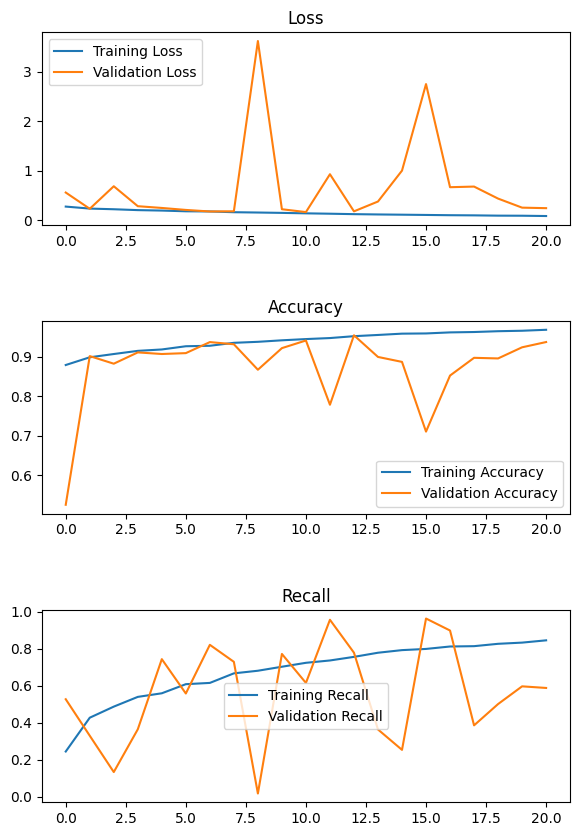

In [41]:
plt.figure(figsize=(15, 10))

plt.subplot(3,2,1)
plt.title('Loss')
plt.plot(history.history['loss'] + history2.history['loss'] + history3.history["loss"] + history4.history["loss"] , label='Training Loss')
plt.legend()
plt.plot(history.history['val_loss'] + history2.history['val_loss'] + history3.history["val_loss"] + history4.history["val_loss"], label='Validation Loss')
plt.legend()

plt.subplot(3,2,3)
plt.title('Accuracy')
plt.plot(history.history['accuracy'] + history2.history['accuracy'] + history3.history["accuracy"] + history4.history["accuracy"], label='Training Accuracy')
plt.legend()
plt.plot(history.history['val_accuracy'] + history2.history['val_accuracy'] + history3.history["val_accuracy"] + history4.history["val_accuracy"], label='Validation Accuracy')
plt.legend()

plt.subplot(3,2,5)
plt.title("Recall")
plt.plot(history.history['recall_1'] + history2.history['recall_1'] + history3.history["recall_1"] + history4.history["recall_1"], label='Training Recall')
plt.legend()
plt.plot(history.history['val_recall_1'] + history2.history['val_recall_1'] + history3.history["val_recall_1"] + history4.history["val_recall_1"], label='Validation Recall')
plt.legend()

plt.subplots_adjust(hspace=0.5)  # adjust the space between plots
plt.show()

In [42]:
history5 = model_custom.fit(train_dataset, validation_data=cv_dataset, epochs=20, callbacks=[checkpoint_val_loss, check_point_recall])


Epoch 1/20
   1747/Unknown 429s 244ms/step - accuracy: 0.9679 - loss: 0.0839 - recall_1: 0.8442

2024-05-04 02:02:52.078852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 02:02:52.079251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 449s 256ms/step - accuracy: 0.9679 - loss: 0.0839 - recall_1: 0.8442 - val_accuracy: 0.7373 - val_loss: 4.2879 - val_recall_1: 0.9400
Epoch 2/20


2024-05-04 02:03:11.839639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 02:03:11.839808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with recall available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9689 - loss: 0.0823 - recall_1: 0.8555

2024-05-04 02:10:17.117270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 02:10:17.117890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 441s 252ms/step - accuracy: 0.9689 - loss: 0.0823 - recall_1: 0.8555 - val_accuracy: 0.6686 - val_loss: 6.5786 - val_recall_1: 0.9535
Epoch 3/20


2024-05-04 02:10:33.072458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 02:10:33.072635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9707 - loss: 0.0774 - recall_1: 0.8653

2024-05-04 02:17:37.470552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 02:17:37.471126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 441s 252ms/step - accuracy: 0.9707 - loss: 0.0774 - recall_1: 0.8653 - val_accuracy: 0.8733 - val_loss: 0.3317 - val_recall_1: 0.8093
Epoch 4/20


2024-05-04 02:17:53.831788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 02:17:53.831874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9721 - loss: 0.0738 - recall_1: 0.8735

2024-05-04 02:25:10.064430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 02:25:10.064953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 452s 259ms/step - accuracy: 0.9721 - loss: 0.0738 - recall_1: 0.8735 - val_accuracy: 0.9257 - val_loss: 0.3198 - val_recall_1: 0.6050
Epoch 5/20


2024-05-04 02:25:26.324402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 02:25:26.324512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9746 - loss: 0.0685 - recall_1: 0.8860

2024-05-04 02:32:40.789368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 02:32:40.789855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 451s 258ms/step - accuracy: 0.9746 - loss: 0.0685 - recall_1: 0.8860 - val_accuracy: 0.8719 - val_loss: 0.9971 - val_recall_1: 0.2236
Epoch 6/20


2024-05-04 02:32:57.202797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 02:32:57.202965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9753 - loss: 0.0671 - recall_1: 0.8889

2024-05-04 02:40:15.736347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 02:40:15.737475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-04 02:40:31.996634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 02:40:31.996704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-04 02:40:31.997107: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 02:40:31.997209: I tensorflow/core/framework/local_re

1747/1747 ━━━━━━━━━━━━━━━━━━━━ 456s 261ms/step - accuracy: 0.9753 - loss: 0.0671 - recall_1: 0.8889 - val_accuracy: 0.9647 - val_loss: 0.1316 - val_recall_1: 0.8277
Epoch 7/20
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9787 - loss: 0.0593 - recall_1: 0.9090

2024-05-04 02:47:50.110735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 02:47:50.111244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 453s 259ms/step - accuracy: 0.9787 - loss: 0.0593 - recall_1: 0.9090 - val_accuracy: 0.6889 - val_loss: 8.3935 - val_recall_1: 0.9758
Epoch 8/20


2024-05-04 02:48:06.478142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 02:48:06.478354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9798 - loss: 0.0528 - recall_1: 0.9088

2024-05-04 02:55:22.520624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 02:55:22.520754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 452s 258ms/step - accuracy: 0.9798 - loss: 0.0528 - recall_1: 0.9088 - val_accuracy: 0.9356 - val_loss: 0.3189 - val_recall_1: 0.5663
Epoch 9/20


2024-05-04 02:55:38.654155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 02:55:38.654307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9807 - loss: 0.0519 - recall_1: 0.9161

2024-05-04 03:02:55.354455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 03:02:55.354981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 453s 259ms/step - accuracy: 0.9807 - loss: 0.0519 - recall_1: 0.9161 - val_accuracy: 0.9324 - val_loss: 0.3872 - val_recall_1: 0.5566
Epoch 10/20


2024-05-04 03:03:11.523994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 03:03:11.524050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-04 03:03:11.524134: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 03:03:11.524184: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9430751880462485458


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9814 - loss: 0.0506 - recall_1: 0.9207

2024-05-04 03:10:30.559405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 03:10:30.560005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 455s 260ms/step - accuracy: 0.9814 - loss: 0.0506 - recall_1: 0.9207 - val_accuracy: 0.9430 - val_loss: 0.1877 - val_recall_1: 0.8858
Epoch 11/20


2024-05-04 03:10:46.826682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 03:10:46.826935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9806 - loss: 0.0502 - recall_1: 0.9143

2024-05-04 03:18:00.606812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 03:18:00.607429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 449s 257ms/step - accuracy: 0.9806 - loss: 0.0502 - recall_1: 0.9143 - val_accuracy: 0.7853 - val_loss: 2.1126 - val_recall_1: 0.9661
Epoch 12/20


2024-05-04 03:18:16.222286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 03:18:16.222354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-04 03:18:16.222370: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 03:18:16.222378: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9430751880462485458


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9838 - loss: 0.0419 - recall_1: 0.9297

2024-05-04 03:25:31.651151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 03:25:31.652254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 452s 258ms/step - accuracy: 0.9838 - loss: 0.0419 - recall_1: 0.9297 - val_accuracy: 0.8162 - val_loss: 1.4364 - val_recall_1: 0.9681
Epoch 13/20


2024-05-04 03:25:47.815319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 03:25:47.815409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9837 - loss: 0.0428 - recall_1: 0.9307

2024-05-04 03:33:03.333377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 03:33:03.333994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 452s 258ms/step - accuracy: 0.9837 - loss: 0.0428 - recall_1: 0.9307 - val_accuracy: 0.9319 - val_loss: 0.3455 - val_recall_1: 0.5866
Epoch 14/20


2024-05-04 03:33:19.491492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 03:33:19.491555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-04 03:33:19.491570: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 03:33:19.491576: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9430751880462485458


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9834 - loss: 0.0437 - recall_1: 0.9280

2024-05-04 03:40:33.631588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 03:40:33.632118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 450s 257ms/step - accuracy: 0.9834 - loss: 0.0437 - recall_1: 0.9280 - val_accuracy: 0.9386 - val_loss: 0.3448 - val_recall_1: 0.5712
Epoch 15/20


2024-05-04 03:40:49.797568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 03:40:49.797649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-04 03:40:49.797669: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 03:40:49.797709: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9430751880462485458


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9851 - loss: 0.0400 - recall_1: 0.9349

2024-05-04 03:48:03.689919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 03:48:03.690681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 450s 257ms/step - accuracy: 0.9851 - loss: 0.0400 - recall_1: 0.9349 - val_accuracy: 0.6714 - val_loss: 10.4970 - val_recall_1: 0.9816
Epoch 16/20


2024-05-04 03:48:19.925562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 03:48:19.925668: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 03:48:19.925711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9870 - loss: 0.0357 - recall_1: 0.9460

2024-05-04 03:55:34.624863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 03:55:34.625304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 451s 258ms/step - accuracy: 0.9870 - loss: 0.0357 - recall_1: 0.9460 - val_accuracy: 0.7818 - val_loss: 3.4006 - val_recall_1: 0.9293
Epoch 17/20


2024-05-04 03:55:50.786491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 03:55:50.786578: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 03:55:50.786620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9870 - loss: 0.0359 - recall_1: 0.9452

2024-05-04 04:03:05.594991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 04:03:05.596106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 451s 258ms/step - accuracy: 0.9870 - loss: 0.0359 - recall_1: 0.9452 - val_accuracy: 0.7839 - val_loss: 2.8931 - val_recall_1: 0.9313
Epoch 18/20


2024-05-04 04:03:22.246281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 04:03:22.246345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-04 04:03:22.246362: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 04:03:22.246397: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9430751880462485458


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9873 - loss: 0.0335 - recall_1: 0.9466

2024-05-04 04:10:39.805959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 04:10:39.806476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 454s 260ms/step - accuracy: 0.9873 - loss: 0.0335 - recall_1: 0.9466 - val_accuracy: 0.9097 - val_loss: 0.4622 - val_recall_1: 0.5102
Epoch 19/20


2024-05-04 04:10:56.096353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 04:10:56.096783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9874 - loss: 0.0343 - recall_1: 0.9482

2024-05-04 04:18:10.533674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 04:18:10.534048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 451s 258ms/step - accuracy: 0.9874 - loss: 0.0343 - recall_1: 0.9482 - val_accuracy: 0.8917 - val_loss: 0.3614 - val_recall_1: 0.6515
Epoch 20/20


2024-05-04 04:18:26.737130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 04:18:26.737239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9884 - loss: 0.0301 - recall_1: 0.9527

2024-05-04 04:25:44.167929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 04:25:44.168603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 454s 260ms/step - accuracy: 0.9884 - loss: 0.0301 - recall_1: 0.9527 - val_accuracy: 0.9098 - val_loss: 0.5183 - val_recall_1: 0.9235


2024-05-04 04:26:00.720784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 04:26:00.720866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


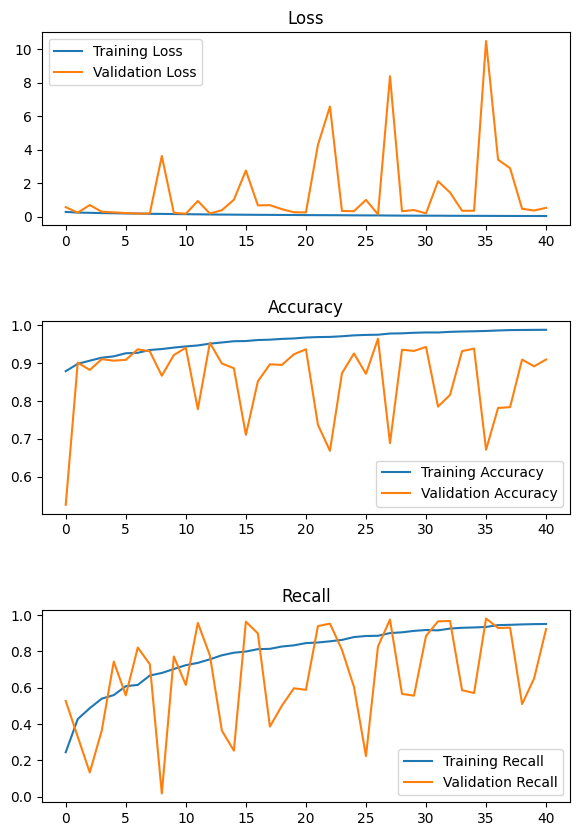

In [43]:
plt.figure(figsize=(15, 10))

plt.subplot(3,2,1)
plt.title('Loss')
plt.plot(history.history['loss'] + history2.history['loss'] + history3.history["loss"] + history4.history["loss"]  + history5.history["loss"] , label='Training Loss')
plt.legend()
plt.plot(history.history['val_loss'] + history2.history['val_loss'] + history3.history["val_loss"] + history4.history["val_loss"] + history5.history["val_loss"], label='Validation Loss')
plt.legend()

plt.subplot(3,2,3)
plt.title('Accuracy')
plt.plot(history.history['accuracy'] + history2.history['accuracy'] + history3.history["accuracy"] + history4.history["accuracy"] + history5.history["accuracy"], label='Training Accuracy')
plt.legend()
plt.plot(history.history['val_accuracy'] + history2.history['val_accuracy'] + history3.history["val_accuracy"] + history4.history["val_accuracy"] + history5.history["val_accuracy"], label='Validation Accuracy')
plt.legend()

plt.subplot(3,2,5)
plt.title("Recall")
plt.plot(history.history['recall_1'] + history2.history['recall_1'] + history3.history["recall_1"] + history4.history["recall_1"] + history5.history["recall_1"], label='Training Recall')
plt.legend()
plt.plot(history.history['val_recall_1'] + history2.history['val_recall_1'] + history3.history["val_recall_1"] + history4.history["val_recall_1"] + history5.history["val_recall_1"], label='Validation Recall')
plt.legend()

plt.subplots_adjust(hspace=0.5)  # adjust the space between plots
plt.show()

In [44]:
history6 = model_custom.fit(train_dataset, validation_data=cv_dataset, epochs=50, callbacks=[checkpoint_val_loss, check_point_recall])


Epoch 1/50
   1747/Unknown 439s 251ms/step - accuracy: 0.9891 - loss: 0.0305 - recall_1: 0.9536

2024-05-04 04:42:18.874867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 04:42:18.875739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 455s 260ms/step - accuracy: 0.9891 - loss: 0.0305 - recall_1: 0.9536 - val_accuracy: 0.8603 - val_loss: 0.9019 - val_recall_1: 0.6147
Epoch 2/50


2024-05-04 04:42:35.031929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 04:42:35.032032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with recall available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9884 - loss: 0.0315 - recall_1: 0.9518

2024-05-04 04:49:48.499194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 04:49:48.499641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 450s 257ms/step - accuracy: 0.9884 - loss: 0.0315 - recall_1: 0.9518 - val_accuracy: 0.8985 - val_loss: 0.4768 - val_recall_1: 0.9593
Epoch 3/50


2024-05-04 04:50:04.648307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 04:50:04.648386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9913 - loss: 0.0242 - recall_1: 0.9608

2024-05-04 04:57:18.212730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 04:57:18.213297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 450s 257ms/step - accuracy: 0.9913 - loss: 0.0242 - recall_1: 0.9608 - val_accuracy: 0.7580 - val_loss: 11.3678 - val_recall_1: 0.9342
Epoch 4/50


2024-05-04 04:57:34.351327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 04:57:34.351411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9892 - loss: 0.0286 - recall_1: 0.9579

2024-05-04 05:04:47.629319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 05:04:47.629859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 449s 257ms/step - accuracy: 0.9892 - loss: 0.0286 - recall_1: 0.9579 - val_accuracy: 0.9611 - val_loss: 0.1723 - val_recall_1: 0.7764
Epoch 5/50


2024-05-04 05:05:03.782371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 05:05:03.782469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-04 05:05:03.782661: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9907 - loss: 0.0249 - recall_1: 0.9606

2024-05-04 05:12:16.614683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 05:12:16.615477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 449s 257ms/step - accuracy: 0.9907 - loss: 0.0249 - recall_1: 0.9606 - val_accuracy: 0.8425 - val_loss: 1.6942 - val_recall_1: 0.9400
Epoch 6/50


2024-05-04 05:12:32.702053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 05:12:32.702319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9910 - loss: 0.0242 - recall_1: 0.9645

2024-05-04 05:19:48.268629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 05:19:48.269194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 452s 258ms/step - accuracy: 0.9910 - loss: 0.0242 - recall_1: 0.9645 - val_accuracy: 0.7367 - val_loss: 12.0728 - val_recall_1: 0.9584
Epoch 7/50


2024-05-04 05:20:04.505064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 05:20:04.505156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9908 - loss: 0.0272 - recall_1: 0.9610

2024-05-04 05:27:22.195272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 05:27:22.195511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 454s 260ms/step - accuracy: 0.9908 - loss: 0.0272 - recall_1: 0.9610 - val_accuracy: 0.9534 - val_loss: 0.3121 - val_recall_1: 0.7018
Epoch 8/50


2024-05-04 05:27:38.407450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 05:27:38.407577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9915 - loss: 0.0239 - recall_1: 0.9648

2024-05-04 05:34:55.059434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 05:34:55.060264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 453s 259ms/step - accuracy: 0.9915 - loss: 0.0239 - recall_1: 0.9648 - val_accuracy: 0.8267 - val_loss: 2.7334 - val_recall_1: 0.9313
Epoch 9/50


2024-05-04 05:35:11.272435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 05:35:11.272519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-04 05:35:11.272598: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 05:35:11.272643: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9430751880462485458


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9915 - loss: 0.0228 - recall_1: 0.9644

2024-05-04 05:42:29.031974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 05:42:29.032634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 454s 260ms/step - accuracy: 0.9915 - loss: 0.0228 - recall_1: 0.9644 - val_accuracy: 0.7150 - val_loss: 12.7091 - val_recall_1: 0.9477
Epoch 10/50


2024-05-04 05:42:45.248404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 05:42:45.248483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-04 05:42:45.248500: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 05:42:45.248507: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9430751880462485458


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9925 - loss: 0.0220 - recall_1: 0.9679

2024-05-04 05:50:03.843429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 05:50:03.844169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 455s 260ms/step - accuracy: 0.9925 - loss: 0.0220 - recall_1: 0.9679 - val_accuracy: 0.9132 - val_loss: 0.7033 - val_recall_1: 0.8625
Epoch 11/50


2024-05-04 05:50:20.067557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 05:50:20.067652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9889 - loss: 0.0309 - recall_1: 0.9550

2024-05-04 05:57:35.554574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 05:57:35.554714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 452s 258ms/step - accuracy: 0.9889 - loss: 0.0309 - recall_1: 0.9550 - val_accuracy: 0.8473 - val_loss: 1.9335 - val_recall_1: 0.9497
Epoch 12/50


2024-05-04 05:57:51.720454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 05:57:51.720637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9937 - loss: 0.0187 - recall_1: 0.9756

2024-05-04 06:05:05.419969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 06:05:05.420308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 450s 257ms/step - accuracy: 0.9937 - loss: 0.0187 - recall_1: 0.9756 - val_accuracy: 0.7511 - val_loss: 3.1031 - val_recall_1: 0.3833
Epoch 13/50


2024-05-04 06:05:21.554618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 06:05:21.554889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9936 - loss: 0.0189 - recall_1: 0.9736

2024-05-04 06:12:35.419441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 06:12:35.421135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-04 06:12:52.344581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 06:12:52.344862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-04 06:12:52.345476: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 454s 260ms/step - accuracy: 0.9936 - loss: 0.0189 - recall_1: 0.9736 - val_accuracy: 0.8331 - val_loss: 3.8605 - val_recall_1: 0.9216
Epoch 14/50
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9928 - loss: 0.0198 - recall_1: 0.9705

2024-05-04 06:20:26.394294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 06:20:26.394731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 467s 267ms/step - accuracy: 0.9928 - loss: 0.0198 - recall_1: 0.9705 - val_accuracy: 0.9431 - val_loss: 0.3861 - val_recall_1: 0.7115
Epoch 15/50


2024-05-04 06:20:43.274359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 06:20:43.274426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-04 06:20:43.274457: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 06:20:43.274494: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9430751880462485458


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9935 - loss: 0.0180 - recall_1: 0.9756

2024-05-04 06:28:14.686623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 06:28:14.687318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 468s 268ms/step - accuracy: 0.9935 - loss: 0.0180 - recall_1: 0.9756 - val_accuracy: 0.9451 - val_loss: 0.4463 - val_recall_1: 0.6399
Epoch 16/50


2024-05-04 06:28:31.643300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 06:28:31.643369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-04 06:28:31.643386: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 06:28:31.643393: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9430751880462485458


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9927 - loss: 0.0199 - recall_1: 0.9693

2024-05-04 06:36:02.624579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 06:36:02.625855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 468s 268ms/step - accuracy: 0.9927 - loss: 0.0199 - recall_1: 0.9693 - val_accuracy: 0.9163 - val_loss: 0.6055 - val_recall_1: 0.9071
Epoch 17/50


2024-05-04 06:36:19.604082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 06:36:19.604187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9938 - loss: 0.0180 - recall_1: 0.9754

2024-05-04 06:43:54.044378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 06:43:54.045444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 472s 269ms/step - accuracy: 0.9938 - loss: 0.0180 - recall_1: 0.9754 - val_accuracy: 0.8451 - val_loss: 2.3221 - val_recall_1: 0.3359
Epoch 18/50


2024-05-04 06:44:11.179568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 06:44:11.179663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9923 - loss: 0.0239 - recall_1: 0.9667

2024-05-04 06:51:41.887648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 06:51:41.888500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 468s 267ms/step - accuracy: 0.9923 - loss: 0.0239 - recall_1: 0.9667 - val_accuracy: 0.9513 - val_loss: 0.3854 - val_recall_1: 0.8838
Epoch 19/50


2024-05-04 06:51:58.803341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 06:51:58.803900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9926 - loss: 0.0219 - recall_1: 0.9692

2024-05-04 06:59:30.266684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 06:59:30.266844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 468s 267ms/step - accuracy: 0.9926 - loss: 0.0219 - recall_1: 0.9692 - val_accuracy: 0.7425 - val_loss: 11.8198 - val_recall_1: 0.9593
Epoch 20/50


2024-05-04 06:59:47.020098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 06:59:47.020471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9946 - loss: 0.0157 - recall_1: 0.9768

2024-05-04 07:07:17.799818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 07:07:17.800390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 468s 267ms/step - accuracy: 0.9946 - loss: 0.0157 - recall_1: 0.9768 - val_accuracy: 0.8256 - val_loss: 3.5979 - val_recall_1: 0.9506
Epoch 21/50


2024-05-04 07:07:34.790666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 07:07:34.790944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9945 - loss: 0.0142 - recall_1: 0.9764

2024-05-04 07:15:05.928258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 07:15:05.928519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 468s 267ms/step - accuracy: 0.9945 - loss: 0.0142 - recall_1: 0.9764 - val_accuracy: 0.7467 - val_loss: 11.9750 - val_recall_1: 0.9593
Epoch 22/50


2024-05-04 07:15:22.791319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 07:15:22.791395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-04 07:15:22.791539: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 07:15:22.791582: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9430751880462485458


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9945 - loss: 0.0154 - recall_1: 0.9780

2024-05-04 07:22:55.099365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 07:22:55.099980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 469s 268ms/step - accuracy: 0.9945 - loss: 0.0154 - recall_1: 0.9780 - val_accuracy: 0.9465 - val_loss: 0.3978 - val_recall_1: 0.6738
Epoch 23/50


2024-05-04 07:23:11.928754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 07:23:11.929008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9945 - loss: 0.0153 - recall_1: 0.9771

2024-05-04 07:30:41.215947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 07:30:41.216579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 466s 266ms/step - accuracy: 0.9945 - loss: 0.0153 - recall_1: 0.9771 - val_accuracy: 0.8577 - val_loss: 1.5195 - val_recall_1: 0.9584
Epoch 24/50


2024-05-04 07:30:57.935566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 07:30:57.935747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9945 - loss: 0.0145 - recall_1: 0.9776

2024-05-04 07:38:23.758831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 07:38:23.759548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 463s 264ms/step - accuracy: 0.9945 - loss: 0.0145 - recall_1: 0.9776 - val_accuracy: 0.9283 - val_loss: 0.5911 - val_recall_1: 0.9216
Epoch 25/50


2024-05-04 07:38:40.516668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 07:38:40.516727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-04 07:38:40.516831: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 07:38:40.516875: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9430751880462485458


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9946 - loss: 0.0154 - recall_1: 0.9777

2024-05-04 07:46:23.377784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 07:46:23.378487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 480s 274ms/step - accuracy: 0.9946 - loss: 0.0154 - recall_1: 0.9777 - val_accuracy: 0.8165 - val_loss: 3.6457 - val_recall_1: 0.9332
Epoch 26/50


2024-05-04 07:46:40.436492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 07:46:40.436561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-04 07:46:40.436580: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 07:46:40.436587: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9430751880462485458


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9952 - loss: 0.0129 - recall_1: 0.9803

2024-05-04 07:54:11.225553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 07:54:11.226222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 467s 267ms/step - accuracy: 0.9952 - loss: 0.0129 - recall_1: 0.9803 - val_accuracy: 0.9315 - val_loss: 0.6853 - val_recall_1: 0.5111
Epoch 27/50


2024-05-04 07:54:27.455603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 07:54:27.455671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-04 07:54:27.455688: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 07:54:27.455722: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9430751880462485458


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9953 - loss: 0.0131 - recall_1: 0.9803

2024-05-04 08:01:42.482333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 08:01:42.483108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 451s 258ms/step - accuracy: 0.9953 - loss: 0.0131 - recall_1: 0.9803 - val_accuracy: 0.9533 - val_loss: 0.2728 - val_recall_1: 0.8509
Epoch 28/50


2024-05-04 08:01:58.722286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 08:01:58.722390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-04 08:01:58.722414: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 08:01:58.722423: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9430751880462485458


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9947 - loss: 0.0144 - recall_1: 0.9779

2024-05-04 08:09:13.422780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 08:09:13.423473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 451s 258ms/step - accuracy: 0.9947 - loss: 0.0144 - recall_1: 0.9779 - val_accuracy: 0.9417 - val_loss: 0.4528 - val_recall_1: 0.6292
Epoch 29/50


2024-05-04 08:09:29.611152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 08:09:29.611220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-04 08:09:29.611236: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 08:09:29.611270: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9430751880462485458


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9956 - loss: 0.0126 - recall_1: 0.9823

2024-05-04 08:16:44.026424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 08:16:44.026857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 451s 258ms/step - accuracy: 0.9956 - loss: 0.0126 - recall_1: 0.9823 - val_accuracy: 0.9034 - val_loss: 1.3083 - val_recall_1: 0.3882
Epoch 30/50


2024-05-04 08:17:00.267084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 08:17:00.267185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9954 - loss: 0.0133 - recall_1: 0.9804

2024-05-04 08:24:15.166152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 08:24:15.166707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 451s 258ms/step - accuracy: 0.9954 - loss: 0.0133 - recall_1: 0.9804 - val_accuracy: 0.8696 - val_loss: 1.8397 - val_recall_1: 0.9564
Epoch 31/50


2024-05-04 08:24:31.369458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 08:24:31.369536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-04 08:24:31.369553: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 08:24:31.369560: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9430751880462485458


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9952 - loss: 0.0136 - recall_1: 0.9798

2024-05-04 08:31:45.967569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 08:31:45.968424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 451s 258ms/step - accuracy: 0.9952 - loss: 0.0136 - recall_1: 0.9798 - val_accuracy: 0.8189 - val_loss: 13.1062 - val_recall_1: 0.8867
Epoch 32/50


2024-05-04 08:32:02.249767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 08:32:02.249836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-04 08:32:02.249852: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 08:32:02.249859: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9430751880462485458


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9954 - loss: 0.0131 - recall_1: 0.9819

2024-05-04 08:39:16.653332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 08:39:16.653975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 451s 258ms/step - accuracy: 0.9954 - loss: 0.0131 - recall_1: 0.9819 - val_accuracy: 0.9658 - val_loss: 0.2061 - val_recall_1: 0.8654
Epoch 33/50


2024-05-04 08:39:32.826930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 08:39:32.827168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9961 - loss: 0.0100 - recall_1: 0.9841

2024-05-04 08:46:47.337784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 08:46:47.338396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 451s 258ms/step - accuracy: 0.9961 - loss: 0.0100 - recall_1: 0.9841 - val_accuracy: 0.9451 - val_loss: 0.5051 - val_recall_1: 0.6428
Epoch 34/50


2024-05-04 08:47:03.600910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 08:47:03.601114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9956 - loss: 0.0125 - recall_1: 0.9826

2024-05-04 08:54:18.292166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 08:54:18.292937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 451s 258ms/step - accuracy: 0.9956 - loss: 0.0125 - recall_1: 0.9826 - val_accuracy: 0.7255 - val_loss: 14.1487 - val_recall_1: 0.9642
Epoch 35/50


2024-05-04 08:54:34.482808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 08:54:34.482945: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 08:54:34.482994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9951 - loss: 0.0146 - recall_1: 0.9812

2024-05-04 09:01:48.983567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 09:01:48.984258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 451s 258ms/step - accuracy: 0.9951 - loss: 0.0146 - recall_1: 0.9812 - val_accuracy: 0.9224 - val_loss: 0.6203 - val_recall_1: 0.9158
Epoch 36/50


2024-05-04 09:02:05.218256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 09:02:05.218373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9960 - loss: 0.0139 - recall_1: 0.9835

2024-05-04 09:09:19.784021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 09:09:19.784085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 451s 258ms/step - accuracy: 0.9960 - loss: 0.0139 - recall_1: 0.9835 - val_accuracy: 0.9557 - val_loss: 0.3298 - val_recall_1: 0.7193
Epoch 37/50


2024-05-04 09:09:35.936449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 09:09:35.936530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9956 - loss: 0.0117 - recall_1: 0.9818

2024-05-04 09:16:50.024907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 09:16:50.025793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 450s 258ms/step - accuracy: 0.9956 - loss: 0.0117 - recall_1: 0.9818 - val_accuracy: 0.7084 - val_loss: 16.1742 - val_recall_1: 0.9797
Epoch 38/50


2024-05-04 09:17:06.205894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 09:17:06.206009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9963 - loss: 0.0104 - recall_1: 0.9842

2024-05-04 09:24:20.405605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 09:24:20.406026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 450s 258ms/step - accuracy: 0.9963 - loss: 0.0104 - recall_1: 0.9842 - val_accuracy: 0.7561 - val_loss: 12.7220 - val_recall_1: 0.9797
Epoch 39/50


2024-05-04 09:24:36.566551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 09:24:36.566698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9957 - loss: 0.0125 - recall_1: 0.9822

2024-05-04 09:31:50.840979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 09:31:50.841832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 450s 257ms/step - accuracy: 0.9957 - loss: 0.0125 - recall_1: 0.9822 - val_accuracy: 0.9474 - val_loss: 0.4959 - val_recall_1: 0.6341
Epoch 40/50


2024-05-04 09:32:06.999801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 09:32:06.999934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9959 - loss: 0.0121 - recall_1: 0.9818

2024-05-04 09:39:21.054737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 09:39:21.054978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 450s 257ms/step - accuracy: 0.9959 - loss: 0.0121 - recall_1: 0.9818 - val_accuracy: 0.9585 - val_loss: 0.3536 - val_recall_1: 0.7377
Epoch 41/50


2024-05-04 09:39:37.227326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 09:39:37.227426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9967 - loss: 0.0104 - recall_1: 0.9855

2024-05-04 09:46:51.345942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 09:46:51.346481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 450s 258ms/step - accuracy: 0.9967 - loss: 0.0105 - recall_1: 0.9855 - val_accuracy: 0.7028 - val_loss: 11.0522 - val_recall_1: 0.9777
Epoch 42/50


2024-05-04 09:47:07.539773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 09:47:07.539875: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 09:47:07.539922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9962 - loss: 0.0106 - recall_1: 0.9844

2024-05-04 09:54:21.554347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 09:54:21.555040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 450s 257ms/step - accuracy: 0.9962 - loss: 0.0106 - recall_1: 0.9844 - val_accuracy: 0.9289 - val_loss: 0.4943 - val_recall_1: 0.6999
Epoch 43/50


2024-05-04 09:54:37.728710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 09:54:37.728802: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 09:54:37.728845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9956 - loss: 0.0118 - recall_1: 0.9832

2024-05-04 10:01:52.022649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 10:01:52.022948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 450s 258ms/step - accuracy: 0.9956 - loss: 0.0118 - recall_1: 0.9832 - val_accuracy: 0.9257 - val_loss: 0.5234 - val_recall_1: 0.9080
Epoch 44/50


2024-05-04 10:02:08.193068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 10:02:08.193152: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 10:02:08.193195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9958 - loss: 0.0109 - recall_1: 0.9835

2024-05-04 10:09:22.518216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 10:09:22.518824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 450s 258ms/step - accuracy: 0.9958 - loss: 0.0109 - recall_1: 0.9835 - val_accuracy: 0.8927 - val_loss: 1.3432 - val_recall_1: 0.4569
Epoch 45/50


2024-05-04 10:09:38.687656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 10:09:38.687731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-04 10:09:38.687748: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 10:09:38.687755: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9430751880462485458


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9969 - loss: 0.0094 - recall_1: 0.9889

2024-05-04 10:16:52.898561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 10:16:52.898646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 450s 258ms/step - accuracy: 0.9969 - loss: 0.0094 - recall_1: 0.9889 - val_accuracy: 0.9676 - val_loss: 0.2131 - val_recall_1: 0.8712
Epoch 46/50


2024-05-04 10:17:09.030491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 10:17:09.030747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9971 - loss: 0.0090 - recall_1: 0.9880

2024-05-04 10:24:23.099726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 10:24:23.100108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 450s 258ms/step - accuracy: 0.9971 - loss: 0.0090 - recall_1: 0.9880 - val_accuracy: 0.9539 - val_loss: 0.3606 - val_recall_1: 0.6854
Epoch 47/50


2024-05-04 10:24:39.283020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 10:24:39.283091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-04 10:24:39.283110: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 10:24:39.283145: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9430751880462485458


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9965 - loss: 0.0107 - recall_1: 0.9858

2024-05-04 10:31:53.549053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 10:31:53.549992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 450s 258ms/step - accuracy: 0.9965 - loss: 0.0107 - recall_1: 0.9858 - val_accuracy: 0.6937 - val_loss: 25.1196 - val_recall_1: 0.9642
Epoch 48/50


2024-05-04 10:32:09.732201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 10:32:09.732305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-04 10:32:09.732351: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9962 - loss: 0.0101 - recall_1: 0.9868

2024-05-04 10:39:24.197097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 10:39:24.197287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 451s 258ms/step - accuracy: 0.9962 - loss: 0.0101 - recall_1: 0.9868 - val_accuracy: 0.8455 - val_loss: 8.3057 - val_recall_1: 0.8587
Epoch 49/50


2024-05-04 10:39:40.353315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 10:39:40.353390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-04 10:39:40.353409: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14851055067163847366
2024-05-04 10:39:40.353446: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9430751880462485458


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9965 - loss: 0.0105 - recall_1: 0.9844

2024-05-04 10:46:55.723260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 10:46:55.724087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 452s 258ms/step - accuracy: 0.9965 - loss: 0.0105 - recall_1: 0.9844 - val_accuracy: 0.8603 - val_loss: 4.7913 - val_recall_1: 0.2546
Epoch 50/50


2024-05-04 10:47:11.926645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 10:47:11.926806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9967 - loss: 0.0086 - recall_1: 0.9880

2024-05-04 10:54:26.361314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 10:54:26.361830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 451s 258ms/step - accuracy: 0.9967 - loss: 0.0086 - recall_1: 0.9880 - val_accuracy: 0.8232 - val_loss: 1.4096 - val_recall_1: 0.4627


2024-05-04 10:54:42.539235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 10:54:42.539331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


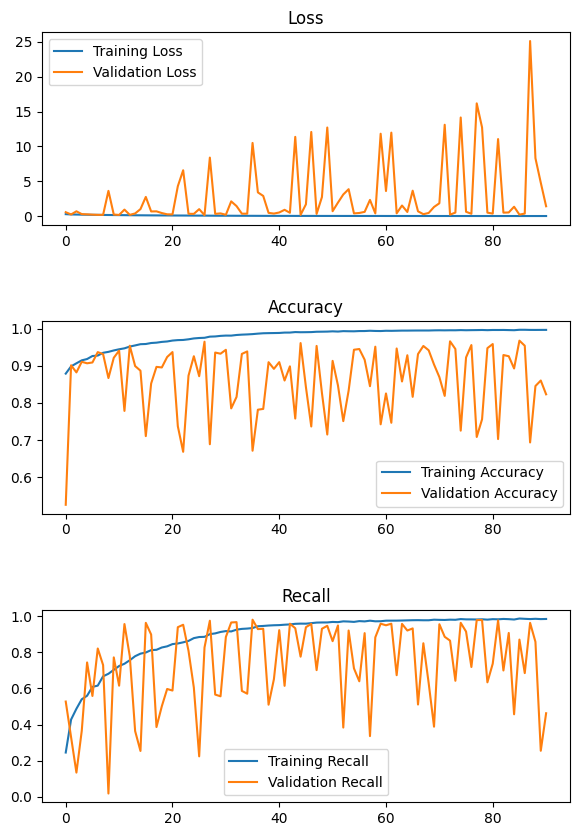

In [45]:
plt.figure(figsize=(15, 10))

plt.subplot(3,2,1)
plt.title('Loss')
plt.plot(history.history['loss'] + history2.history['loss'] + history3.history["loss"] + history4.history["loss"]  + history5.history["loss"] + history6.history["loss"] , label='Training Loss')
plt.legend()
plt.plot(history.history['val_loss'] + history2.history['val_loss'] + history3.history["val_loss"] + history4.history["val_loss"] + history5.history["val_loss"] + history6.history["val_loss"], label='Validation Loss')
plt.legend()

plt.subplot(3,2,3)
plt.title('Accuracy')
plt.plot(history.history['accuracy'] + history2.history['accuracy'] + history3.history["accuracy"] + history4.history["accuracy"] + history5.history["accuracy"] + history6.history["accuracy"], label='Training Accuracy')
plt.legend()
plt.plot(history.history['val_accuracy'] + history2.history['val_accuracy'] + history3.history["val_accuracy"] + history4.history["val_accuracy"] + history5.history["val_accuracy"] + history6.history["val_accuracy"], label='Validation Accuracy')
plt.legend()

plt.subplot(3,2,5)
plt.title("Recall")
plt.plot(history.history['recall_1'] + history2.history['recall_1'] + history3.history["recall_1"] + history4.history["recall_1"] + history5.history["recall_1"] + history6.history["recall_1"], label='Training Recall')
plt.legend()
plt.plot(history.history['val_recall_1'] + history2.history['val_recall_1'] + history3.history["val_recall_1"] + history4.history["val_recall_1"] + history5.history["val_recall_1"] + history6.history["val_recall_1"], label='Validation Recall')
plt.legend()

plt.subplots_adjust(hspace=0.5)  # adjust the space between plots
plt.show()

In [46]:
model_custom.save("custom_model_90.keras")

In [51]:

fig, ax1 = plt.subplots()

# Plotting the training loss on the primary y-axis
ax1.plot(history.history['loss'] + history2.history['loss'] + history3.history["loss"] + history4.history["loss"] + history5.history["loss"] + history6.history["loss"], label='Training Loss', color='tab:blue')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Creating a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(history.history['val_loss'] + history2.history['val_loss'] + history3.history["val_loss"] + history4.history["val_loss"] + history5.history["val_loss"] + history6.history["val_loss"], label='Validation Loss', color='tab:red')
ax2.set_ylabel('Validation Loss', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Adding a title and a legend
plt.title('Training and Validation Loss')
fig.tight_layout()
plt.show()


In [56]:
history7 = model_custom.fit(train_dataset, validation_data=cv_dataset, epochs=50, callbacks=[checkpoint_val_loss, check_point_recall])


: 